In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import pandas as pd
import glob

dB = lambda x: 10*np.log10(x) # convert mag. to dB

# %load_ext autoreload # auto reload files
# %autoreload 2

In [2]:
import glob

path = 'data/ganglion/eeg_ssvep*_LED*' # use your path
all_files = glob.glob(path)

dfs = []

for filename in all_files:
    print(f"Loading file {filename}")
    f = np.load(filename, allow_pickle=True) 
    dfs.append(pd.DataFrame(f['data'], columns=[f'chan{i+1}' for i in range(4)]))

Loading file data/ganglion/eeg_ssvep10Hz_04-04T17:52:15_LED.npz
Loading file data/ganglion/eeg_ssvep10Hz_04-04T17:56:39_LED_Oz.npz


In [87]:
from eeg_lib.utils import read_json
import json

test = "test-256Hz-filt-12Hzstim"
all_data = read_json('eeg_lib/log_data.json')
data = {}

for label, values in all_data.items():
    if str(test) in label:
        print(test)
        data[label] = np.array([json.loads(values[i]) for i in range(len(values))])

test-256Hz-filt-12Hzstim


In [16]:
# list(data.values())[0][0]

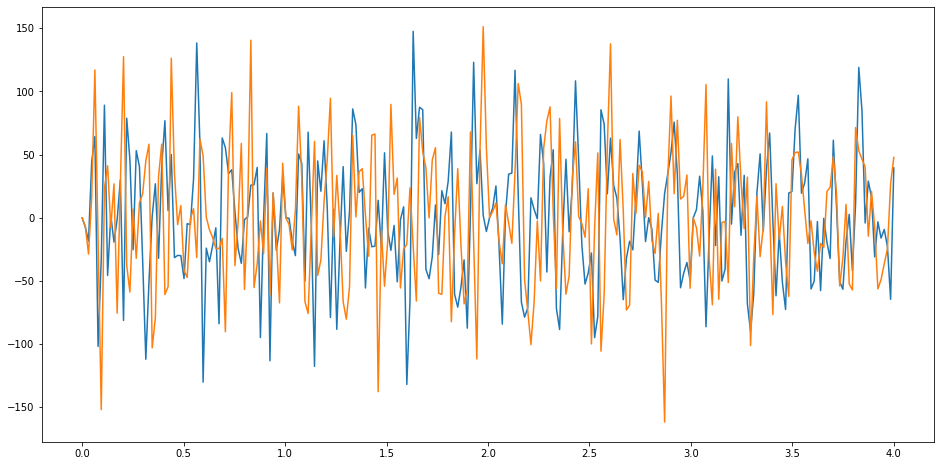

In [88]:
trials = list(data.keys())

plt.figure(figsize=(16, 8))

X = data[trials[0]].T
x = X[:, 1]

t = np.linspace(0, 4, num=len(X))
plt.plot(t, X[:, -2:])
# plt.plot(t, x)

In [7]:
from scipy import signal

fs = 128
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)


# sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')
sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, wc_hi, btype='lowpass', output='sos')

In [8]:
sos_ellip

array([[ 0.00489814,  0.00882672,  0.00489814,  1.        , -1.12754282,
         0.37507747],
       [ 1.        ,  0.89364345,  1.        ,  1.        , -0.86464138,
         0.5663009 ],
       [ 1.        ,  0.27438961,  1.        ,  1.        , -0.59631233,
         0.76500326],
       [ 1.        , -0.00656791,  1.        ,  1.        , -0.4363727 ,
         0.89332053],
       [ 1.        , -0.11037337,  1.        ,  1.        , -0.37229848,
         0.96976145]])

In [3]:
sos_bw = signal.butter(10, [1, 28], 'bp', fs=256, output='sos')

In [6]:
# t = np.linspace(0, len(X)/fs, num=len(X))

x = X[:, 2]

t = np.linspace(0, 4, num=len(X))

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(16, 8))
ax0.plot(t, x)

x_sos_ellip = signal.sosfilt(sos_ellip, x-np.mean(x))#[::2]
x_sos_bw = signal.sosfilt(sos_bw, x-np.mean(x))#[::2]
t_ds = np.linspace(0, 4, num=len(x_sos_ellip))

x_range = np.max(x)-np.min(x)
ax1.plot(t_ds, x_sos_ellip, c='g', label='elliptical')
ax1.plot(t_ds, x_sos_bw, c='r', label='butterworth')
ax1.set_ylim(-x_range/2, x_range/2) # optional
ax1.legend()


In [5]:
sos_ellip

array([[ 5.18442631e-04,  5.91022291e-04,  5.18442631e-04,
         1.00000000e+00, -1.58700686e+00,  6.47826110e-01],
       [ 1.00000000e+00, -6.71721317e-01,  1.00000000e+00,
         1.00000000e+00, -1.56164716e+00,  7.42956116e-01],
       [ 1.00000000e+00, -1.19862825e+00,  1.00000000e+00,
         1.00000000e+00, -1.53434369e+00,  8.53024717e-01],
       [ 1.00000000e+00, -1.36462221e+00,  1.00000000e+00,
         1.00000000e+00, -1.52074686e+00,  9.31086238e-01],
       [ 1.00000000e+00, -1.41821305e+00,  1.00000000e+00,
         1.00000000e+00, -1.52570664e+00,  9.80264626e-01]])

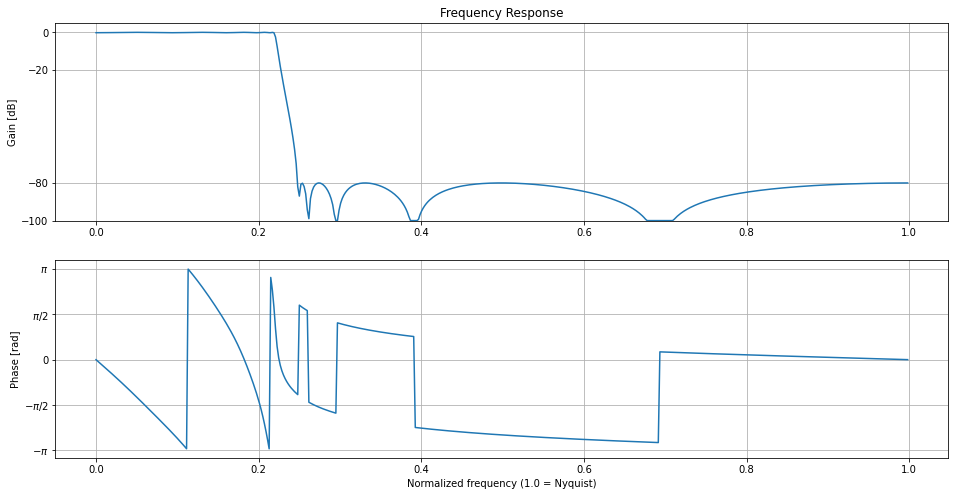

In [74]:
w, h = signal.sosfreqz(sos_ellip, worN=512)

plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w/np.pi, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([0, -20, -80, -100])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

In [57]:
# plot_periodogram(x_sos_ellip, 256, N=256, figsize=(14, 8))

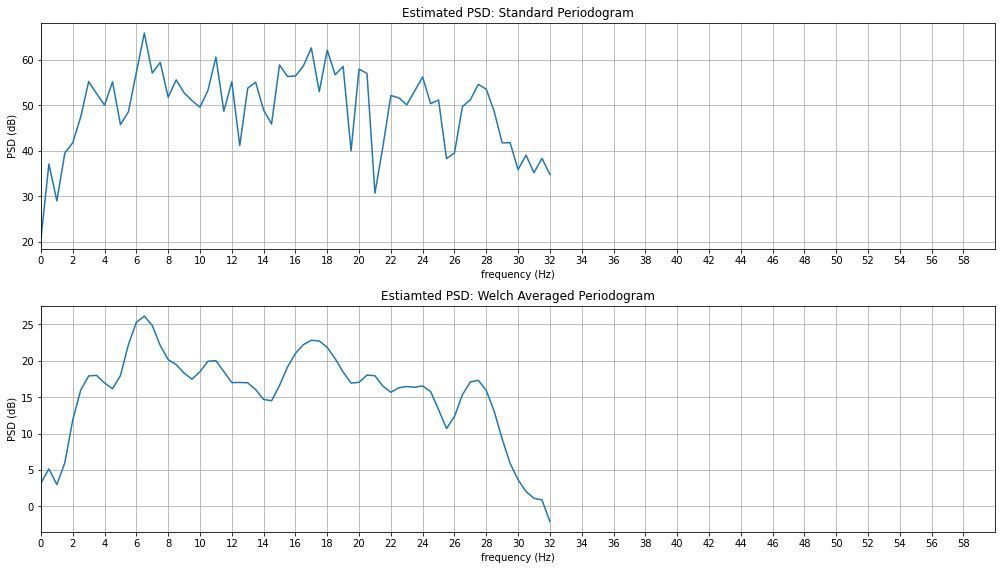

In [89]:
from eeg_lib.freq_analysis import plot_periodogram


x = X[:, 1]

plot_periodogram(x, 64, N=128, figsize=(14, 8))

In [154]:
# chi = X.reshape((1, len(X), -1))
# chi_train = chi[:, :, :-1]
# X_test = chi[:, :, -1]

cca = CCA([7, 10, 12], 64)
cca.compute_corr(x.reshape((1, len(x))))

{7: array([0.11579123]), 10: array([0.09612585]), 12: array([0.05728097])}

In [106]:
def standardise(X):
    axis = np.argmax(X.shape())
    minor_shape = np.min(X.shape())
    mu = np.mean(X, axis=axis).reshape((minor_shape, 1))
    sigma = np.std(X, axis=axis).reshape((minor_shape, 1))
    return (X-mu)/sigma

def solve_eig_qr(A, iterations=30):

    Ak = A
    Q_bar = np.eye(len(Ak))

    for _ in range(iterations):
        Qk, Rk = np.linalg.qr(Ak)
        Ak = np.dot(Rk, Qk)
        Q_bar = np.dot(Q_bar, Qk)

    lam = np.diag(Ak)
    return lam, Q_bar

def harmonic_reference(f0, fs, Ns, Nh=1, standardise_out=False):
    
    '''
    Generate reference signals for canonical correlation analysis (CCA)
    -based steady-state visual evoked potentials (SSVEPs) detection [1, 2].
    function [ y_ref ] = cca_reference(listFreq, fs,  Ns, Nh) 
    Input:
      f0        : stimulus frequency
      fs              : Sampling frequency
      Ns              : # of samples in trial
      Nh          : # of harmonics
    Output:
      y_ref           : Generated reference signals with shape (Nf, Ns, 2*Nh)
    '''  
    X = np.zeros((Nh*2, Ns))
    
    for harm_i in range(Nh):
        # Sin and Cos
        X[2*harm_i, :] = np.sin(np.arange(1,Ns+1)*(1/fs)*2*np.pi*(harm_i+1)*f0)
        X[2*harm_i+1, :] = np.cos(np.arange(1,Ns+1)*(1/fs)*2*np.pi*(harm_i+1)*f0)

    # print(micropython.mem_info(1))
    if standardise_out: # zero mean, unit std. dev
        return standardise(X)
    return X

class CCA():
    
    def __init__(self, stim_freqs, fs, Nh=2):
        self.Nh = Nh
        self.stim_freqs = stim_freqs
        self.fs = fs
        
    def compute_corr(self, X_test):            
        result = {}
        Cxx = np.dot(X_test, X_test.transpose()) # precompute data auto correlation matrix
        for f in self.stim_freqs:
            Y = harmonic_reference(f, self.fs, np.max(X_test.shape), Nh=self.Nh, standardise_out=False)
            rho = self.cca_eig(X_test, Y, Cxx=Cxx) # canonical variable matrices. Xc = X^T.W_x
            result[f] = rho
        return result
    
    @staticmethod
    def cca_eig(X, Y, Cxx=None, eps=1e-6):
        if Cxx is None:
            Cxx = np.dot(X, X.transpose()) # auto correlation matrix
        Cyy = np.dot(Y, Y.transpose()) 
        Cxy = np.dot(X, Y.transpose()) # cross correlation matrix
        Cyx = np.dot(Y, X.transpose()) # same as Cxy.T

        M1 = np.dot(np.linalg.inv(Cxx+eps), Cxy) # intermediate result
        M2 = np.dot(np.linalg.inv(Cyy+eps), Cyx)

        lam, _ = solve_eig_qr(np.dot(M1, M2), 20)
        return np.sqrt(lam)

### Resampling and Compression

Testing resampling techniques and spare representations

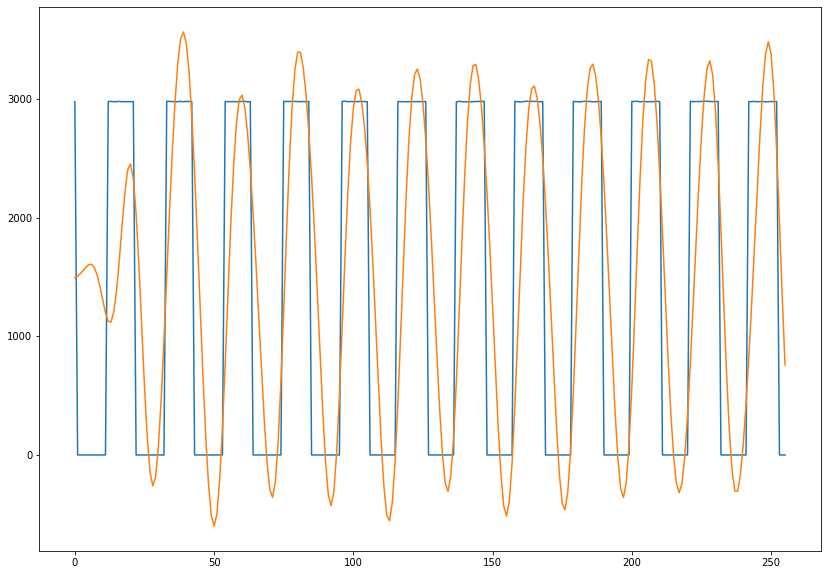

In [207]:
X = np.array([2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2981, 2979, 2979, 2981, 2979, 2979, 2979, 2979, 2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2982, 2981, 2980, 2978, 2979, 2981, 2979, 2981, 2981, 2978, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2979, 2979, 2980, 2979, 2979, 2981, 2983, 2977, 2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2982, 2981, 2980, 2982, 2981, 2980, 2979, 2981, 2979, 2980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2983, 2979, 2980, 2980, 2979, 2981, 2980, 2980, 2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2979, 2979, 2978, 2979, 2980, 2979, 2980, 2979, 2979, 2980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2978, 2982, 2979, 2977, 2979, 2978, 2979, 2980, 2981, 2981, 2981, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2979, 2977, 2979, 2983, 2981, 2982, 2981, 2981, 2978, 2980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2979, 2978, 2979, 2983, 2980, 2981, 2978, 2979, 2980, 2981, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2981, 2981, 2982, 2978, 2981, 2979, 2978, 2980, 2979, 2982, 2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2982, 2979, 2980, 2980, 2981, 2982, 2983, 2980, 2980, 2981, 2979, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2980, 2979, 2981, 2979, 2979, 2981, 2978, 2978, 2981, 2979, 2980, 0, 0, 0])

Y = np.array([6.960638, 17.96047, 39.56479, 65.45015, 93.5072, 114.8652, 117.5076, 90.43438, 27.90186, -67.06119, -180.9851, -291.1903, -363.3474, -368.4974, -281.3911, -99.40826, 159.9115, 455.7556, 729.5594, 917.176, 964.4059, 841.534, 545.9648, 113.8086, -396.7153, -906.9848, -1340.785, -1635.4, -1750.843, -1674.402, -1419.644, -1021.001, -526.2133, 18.05316, 562.2214, 1067.602, 1496.923, 1822.033, 2020.831, 2077.303, 1983.609, 1742.809, 1370.872, 890.1281, 337.5513, -248.3532, -820.0052, -1331.467, -1738.486, -2001.337, -2089.717, -1988.563, -1703.365, -1263.267, -713.3338, -118.7524, 455.1713, 943.7511, 1300.808, 1501.965, 1544.709, 1444.425, 1227.356, 923.1563, 552.8162, 137.49, -308.4642, -760.7599, -1187.478, -1544.775, -1781.041, -1847.95, -1714.55, -1379.41, -876.359, -264.2701, 375.0744, 964.3058, 1436.367, 1753.22, 1905.452, 1905.831, 1778.953, 1550.671, 1241.412, 858.7126, 412.373, -87.26062, -610.6729, -1113.683, -1538.389, -1823.225, -1918.008, -1798.391, -1474.698, -992.1993, -415.7314, 175.0654, 712.0514, 1140.368, 1431.844, 1580.373, 1594.284, 1488.106, 1276.591, 972.8574, 583.9942, 126.1228, -380.3474, -896.7213, -1374.622, -1758.741, -1995.684, -2045.399, -1891.271, -1545.808, -1050.306, -461.6038, 148.8434, 717.4862, 1188.376, 1527.098, 1718.937, 1764.985, 1676.958, 1472.153, 1170.194, 785.4617, 338.8177, -149.2698, -644.6394, -1105.902, -1483.994, -1728.244, -1796.667, -1667.036, -1345.143, -867.4483, -289.8592, 312.9863, 871.9343, 1325.729, 1637.468, 1793.963, 1801.182, 1676.925, 1443.154, 1120.793, 721.8325, 262.3554, -241.9538, -759.4372, -1247.731, -1653.744, -1921.538, -2004.963, -1880.534, -1556.142, -1072.629, -490.5024, 112.9008, 668.7948, 1119.111, 1431.399, 1596.072, 1620.166, 1519.493, 1311.843, 1013.637, 633.984, 188.8837, -303.394, -807.2808, -1277.097, -1658.655, -1897.715, -1951.924, -1802.037, -1458.791, -963.318, -373.8484, 235.9624, 800.6494, 1263.547, 1591.038, 1770.329, 1804.693, 1707.306, 1495.648, 1188.235, 797.7057, 343.4025, -154.741, -661.8728, -1135.009, -1523.323, -1774.99, -1847.959, -1720.967, -1401.265, -919.5594, -335.0469, 284.8765, 866.0811, 1346.594, 1681.381, 1844.945, 1831.073, 1650.257, 1326.259, 893.1271, 386.1824, -149.8085, -672.929, -1136.226, -1499.334, -1730.112, -1808.292, -1728.791, -1502.851, -1156.386, -719.1549, -229.8393, 277.9799, 766.6553, 1201.668, 1547.783, 1769.037, 1832.962, 1718.012, 1422.013, 968.6149, 401.737, -210.0172, -795.1227, -1282.747, -1623.424, -1793.814, -1796.421, -1653.582, -1397.713, -1061.533, -665.1006, -225.4514, 248.209, 735.2614, 1204.205, 1608.017, 1889.575, 1994.92, 1889.583, 1572.03, 1079.203, 474.7865, -155.1361, -731.2887])
Yds = np.array([6.960638, 93.5072, 27.90186, -363.3474, 159.9115, 964.4059, -396.7153, -1750.843, -526.2133, 1496.923, 1983.609, 337.5513, -1738.486, -1703.365, 455.1713, 1544.709, 552.8162, -1187.478, -1714.55, 375.0744, 1905.452, 1241.412, -610.6729, -1918.008, -415.7314, 1431.844, 1276.591, -380.3474, -1995.684, -1050.306, 1188.376, 1676.958, 338.8177, -1483.994, -1345.143, 871.9343, 1801.182, 721.8325, -1247.731, -1880.534, 112.9008, 1596.072, 1013.637, -807.2808, -1951.924, -373.8484, 1591.038, 1495.648, -154.741, -1774.99, -919.5594, 1346.594, 1650.257, -149.8085, -1730.112, -1156.386, 766.6553, 1832.962, 401.737, -1623.424, -1397.713, 248.209, 1889.575, 1079.203])

import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
plt.plot(X)
plt.plot(Y+np.mean(X))

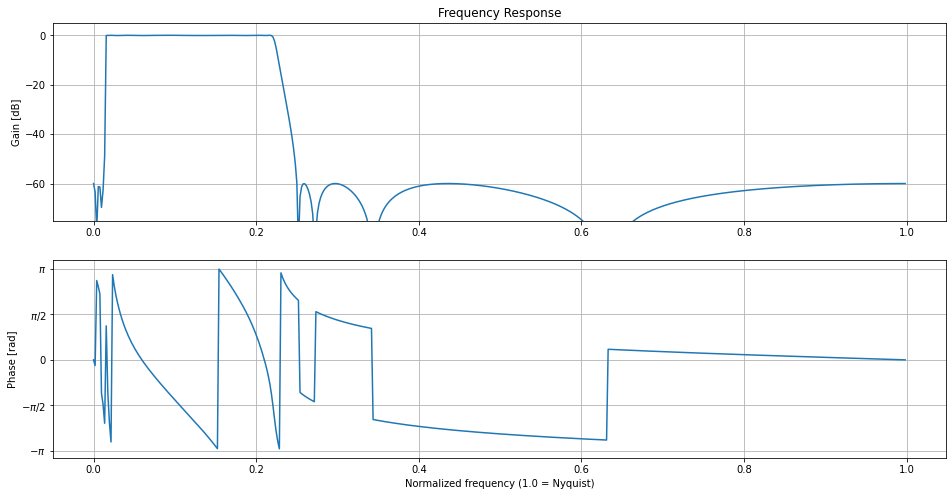

In [160]:
from scipy import signal

fs = 256
filt_ord = 8
pb_rip = 0.1
sb_atten = 60

fc_lo = 2 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)


sos = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')
w, h = signal.sosfreqz(sos, worN=512)

plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w/np.pi, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

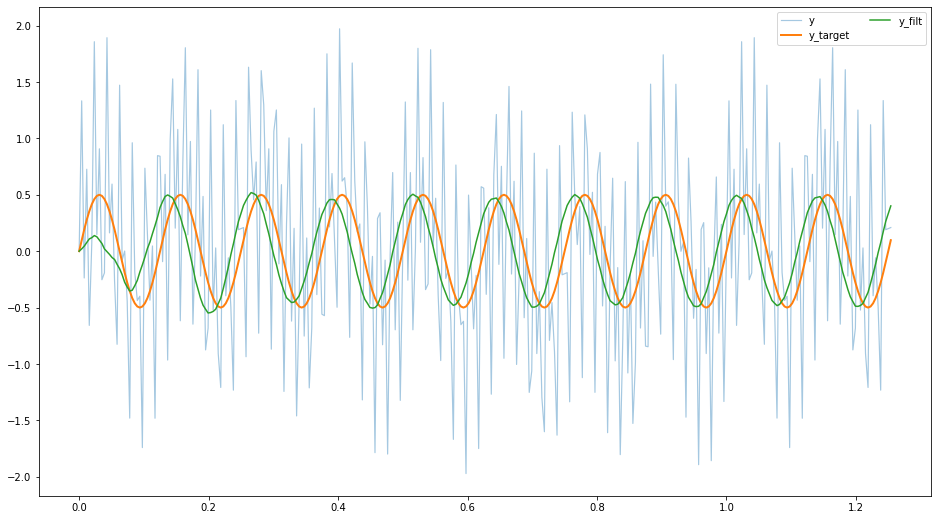

In [166]:
t = np.arange(0, 0.4*np.pi, 1/fs)

arg =2*np.pi*t
y_true = 0.5*np.sin(arg*8)#+0.2*np.sin(arg*16)
y = y_true + 0.9*np.sin(arg*100)+0.2*np.sin(arg*1)+0.7*np.sin(arg*50)
y_sos = signal.sosfilt(sos, y)

plt.figure(figsize=(16,9))
plt.plot(t, y, lw=1.2, alpha=0.4, label="y")
plt.plot(t, y_true, lw=2, label="y_target")
plt.plot(t, y_sos, label="y_filt")

t_ds = t[::4]
y_sos_ds = y_sos[::4]
# plt.plot(t_ds, y_sos_ds, label="y_filt_downsampled")
plt.legend(ncol=2)

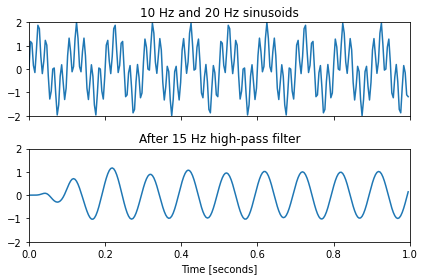

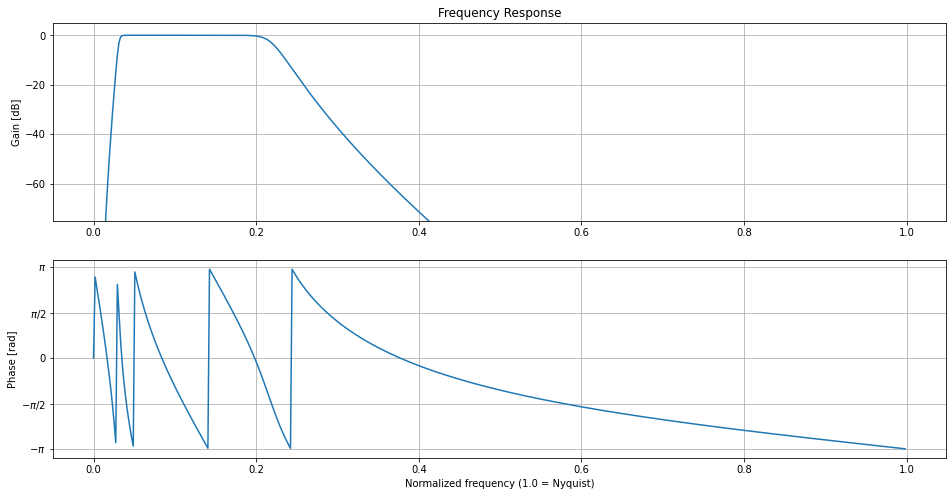

In [187]:
t = np.linspace(0, 1, 256, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*50*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = signal.butter(10, [4, 28], 'bp', fs=256, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

w, h = signal.sosfreqz(sos, worN=512)

plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w/np.pi, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

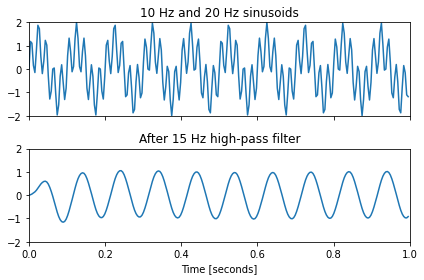

In [184]:
t = np.linspace(0, 1, 256, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*50*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = signal.cheby2(8, 40, [1, 28], 'bandpass', fs=256, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()


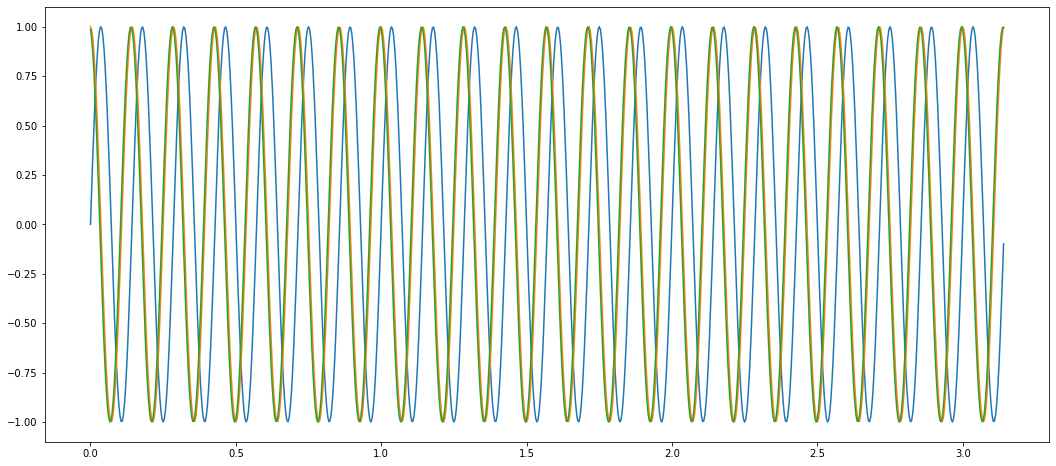

In [25]:
t = np.arange(0, np.pi, 1/fs)
f0 = 7

x1 = np.sin(2*np.pi*f0*t)
x2 = np.sin(2*np.pi*f0*t+np.pi/2) # phase diff

plt.figure(figsize=(18, 8 ))
plt.plot(t, x1)
plt.plot(t, x2)

from eeg_lib.cca import cca_reference

y = cca_reference([f0], fs, len(t), Nh=1)
y.shape

plt.plot(t, y[1, :])

### CCA (canonical correlation analysis)
CCA is a multivariable statistical method used when there are two sets of data, which may have some underlying corre- lation. First, CCA finds a pair of linear combinations, called **canonical variables**, for two sets, such that the correlation between the two canonical variables is maximized. The second set of variables $Y$ is composed of a candidate frequencies and $k$ harmonics. However, due to the low-pass nature of brain dynamics, $k\leq3$ is usually used.

$$
y(t)=\left(\begin{array}{l}
y_{1}(t) \\
y_{2}(t) \\
y_{3}(t) \\
y_{4}(t) \\
y_{5}(t) \\
y_{6}(t)
\end{array}\right)=\left(\begin{array}{c}
\sin (2 \pi f t) \\
\cos (2 \pi f t) \\
\sin (4 \pi f t) \\
\cos (4 \pi f t) \\
\sin (6 \pi f t) \\
\cos (6 \pi f t)
\end{array}\right), \quad {t=\frac{1}{f_s}, \frac{2}{f_s}, \ldots, \frac{N}{f_s}}
$$

Then it finds a second pair, which is uncorrelated with the first pair of canonical variables but has a next highest correlation. The process of constructing canonical variables continues until the number of pairs of canonical variables equals the number of variables in the smaller set (usually $X$). The coefficients describe the correlation relation of the two sets. 


Fundamental SSVEP frequency expected at 10Hz
Fundamental SSVEP frequency expected at 10Hz


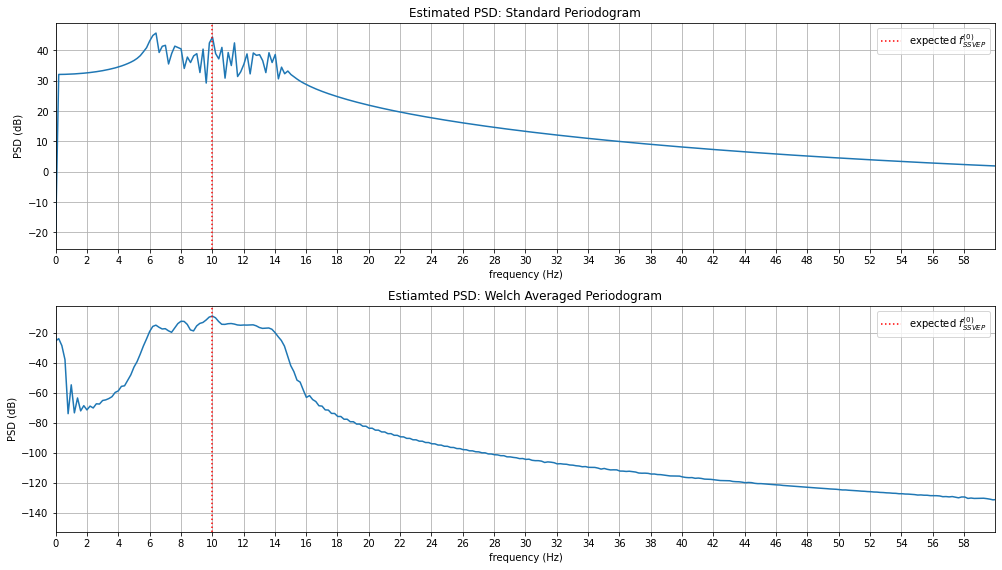

In [8]:
from eeg_lib.cca import cca_reference
from eeg_lib.filtering import iir_notch, butterworth_lowpass, iir_bandpass
from eeg_lib.freq_analysis import plot_periodogram
from eeg_lib.utils import standardise

df = dfs[0][:1000]

notch_50 = False
lowpass_25 = False
bandpass = True

ssvep_f0 = 10

Xraw = df.values
if notch_50:
    Xraw = np.array([iir_notch(Xraw[:, j], 50, 200) for j in range(Xraw.shape[1])]).T
    
if lowpass_25:
    Xraw = np.array([butterworth_lowpass(Xraw[:, j], 25, 200, order=2) for j in range(Xraw.shape[1])]).T
    
if bandpass:
    Xraw = np.array([iir_bandpass(Xraw[:, j], 5, 17, 200, order=8) for j in range(Xraw.shape[1])]).T

X = standardise(Xraw) #[:, -2:] # only choose last two channels: Oz, O1
plot_periodogram(X[:, -1], 200, ssvep_f0=ssvep_f0, N=2048, figsize=(14, 8))

In [3]:
from eeg_lib.cca import cca_reference
import numpy as np

candidate_freqs = [7, 10, 12]

X = np.array([[0.0, 0.2552531, 0.4935954, 0.6992362, 0.8585516, 0.9609866, 0.9997549, 0.972288, 0.8804055, 0.7301948],
       [0.0, 0.2651061, 0.5112409, 0.7207904, 0.8787591, 0.9738424, 0.9992362, 0.9531231, 0.838803, 0.6644569],
       [0.0, 0.2634635, 0.5083104, 0.7172394, 0.8754874, 0.9718722, 0.9995833, 0.9566626, 0.8461428, 0.6758333],
       [0.0, 0.2671577, 0.5148946, 0.7252015, 0.8827904, 0.9762053, 0.9986557, 0.9485094, 0.8294118, 0.6500207]])

# Y = cca_reference([7], 200, 10, Nh=2)

Y = np.array([[-2.171207, -1.338523, -0.5880827, 0.04396701, 0.5271821, 0.8382883, 0.9623005, 0.8932458, 0.6344502, 0.1983788],
       [1.305342, 1.170641, 0.9533603, 0.6639652, 0.3163952, -0.07260892, -0.4843098, -0.8988775, -1.296343, -1.657563],
       [0.2679634, 0.7796801, 1.073691, 1.094033, 0.8368343, 0.3510505, -0.2708505, -0.9104931, -1.446123, -1.775786],
       [1.850696, 1.432374, 0.8242437, 0.1420597, -0.4843266, -0.9356859, -1.126103, -1.019333, -0.6356997, -0.04822552]])

# cca.classify(X.T)

In [23]:
Cxx = X.dot(X.T)
Cxy = X.dot(Y.T)
Cyy = Y.dot(Y.T)
Cyx = Y.dot(X.T)

M1 = np.linalg.inv(Cxx).dot(Cxy)
M2 = np.linalg.inv(Cyy).dot(Cyx)

M = M1.dot(M2)

np.linalg.eig(M)

(array([0.02148729, 0.14447535, 1.00472133, 0.99984663]),
 array([[ 0.02902728,  0.02892596,  0.02260202,  0.02290183],
        [ 0.7939542 ,  0.79404442,  0.79942807,  0.79912809],
        [-0.53426395, -0.53399658, -0.51715765, -0.51825175],
        [-0.28871471, -0.28897127, -0.3048801 , -0.30378435]]))

In [4]:
from eeg_lib.utils import solve_gen_eig_prob

Cxx = X.dot(X.T)
Cxy = X.dot(Y.T)
Cyy = Y.dot(Y.T)
Cyx = Y.dot(X.T)

def block_diag(X, Y, reverse=False):
    if not reverse:
        X = np.concatenate([X, np.zeros_like(X)], axis=1)
        Y = np.concatenate([np.zeros_like(Y), Y], axis=1)
    else:
        X = np.concatenate([np.zeros_like(X), X], axis=1)
        Y = np.concatenate([Y, np.zeros_like(Y)], axis=1)
    return np.concatenate([X, Y], axis=0)

A = block_diag(Cxy, Cyx, reverse=True)
B = block_diag(Cxx, Cyy)

lam, Phi = solve_gen_eig_prob(A, B)

In [101]:
from scipy.linalg import block_diag

A = M1 #np.array([[2, 0], [0, 3]])

n_eig = A.shape[0]
lam_iterations = 20

Ak = A
n_eig = min(n_eig, min(A.shape))

Q_bar = np.eye(*Ak.shape)

for k in range(lam_iterations):
    Qk, Rk = np.linalg.qr(Ak)
    Ak = np.dot(Rk, Qk)
    Q_bar = Q_bar.dot(Qk)

lam = np.diag(Ak)
    
# lam = np.diag(Ak) # get eigenvalues
# V = []
# for l in lam[:n_eig]: # now find `n_eig` eigenvectors
#     A_null = (A - np.eye(A.shape[0])*l).transpose()
#     Q, R = np.linalg.qr(A_null) # compute null space of (A-lam*I) to get eigenvector
#     V.append(Q[:, -1])

V = np.array(V).transpose()
# return lam, V


In [91]:
for i in range(A.shape[0]):
    print(np.linalg.norm(A.dot(Q_bar[:, i])-lam2[i]*Q_bar[:, i]))

18955156925226.3
25140139.220744584
171.6544516593277
0.041489408604638484


In [103]:
lam2, V2 = np.linalg.eig(A)


The covariance matrix is a block matrix where 𝐶𝑥𝑥 and 𝐶𝑦𝑦 are within-set covariance matrices and 𝐶𝑥𝑦=𝐶𝑇𝑦𝑥 are between-sets covariance matrices.

$\begin{bmatrix}C_{xx}&C_{xy} \\ C_{yx}&C_{yy}\end{bmatrix}$

The tutorial says that the canonical correlations between 𝑥 and 𝑦 can be found by solving the eigenvalue equations

$$
\begin{align}
    C_{xx}^{-1} C_{xy} C_{yy}^{-1} C_{yx} \hat{w}_x &= \rho^2 \hat{w}_x \\
    C_{yy}^{-1} C_{yx} C_{xx}^{-1} C_{xy} \hat{w}_y &= \rho^2 \hat{w}_y
\end{align}
$$

where the eigenvalues are the squared canonical correlations and the eigenvectors and are the normalized canonical correlation basis vectors.

<AxesSubplot:>

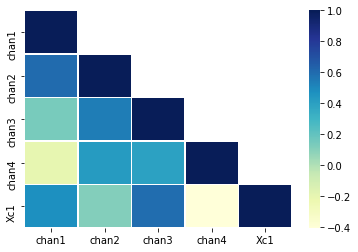

In [13]:
import seaborn as sns

Uw = cca.x_weights_
Vw = cca.y_weights_
print("U1", Uw[:, 0])
print("V1", Vw[:, 0])

dfx = pd.DataFrame(X, columns=[f'chan{i+1}' for i in range(X.shape[1])])
dfx['Xc1'] = Xc

dfx_corr = dfx.corr()
dfx_lt = dfx_corr.where(np.tril(np.ones(dfx_corr.shape)).astype(np.bool))
sns.heatmap(dfx_lt,linewidths=.5, cmap="YlGnBu")

### CCA, GCCA and TRCA
Generalised CCA: a data-driven extension of CCA for multivariate analysis


#### James LED dataset
Flickering LED samples taken with OpenBCI headset. Each 10s long at 200Hz. First 300 samples in each reading discarded. 4 channels: approximately O1, O2, PO1, PO2. Stim freqs 7Hz, 10Hz, 12Hz using blue LED driven by ESP32 (hardware timer).

In [26]:
from eeg_lib.utils import load_trials, standardise_ssvep_tensor
from eeg_lib.cca import GCCA, CCA, MsetCCA_SSVEP
from eeg_lib.trca import TRCA_SSVEP

path_pattern = lambda f: f'data/LED-James/ssvep{f}Hz_*.npz' # use your path
stim_freqs = [7, 10 ,12]
X_ssvep = [load_trials(path_pattern(f), verbose=True) for f in stim_freqs]
min_len = min(x.shape[1] for x in X_ssvep)
X_ssvep = np.array([x[:, :min_len-1, :] for x in X_ssvep]).transpose(0, 3, 2, 1)

X_ssvep = standardise_ssvep_tensor(X_ssvep)

Loading file data/LED-James/ssvep7Hz_05-26T13:47:40_LED.npz
Loading file data/LED-James/ssvep7Hz_05-26T13:47:22_LED.npz
Loading file data/LED-James/ssvep7Hz_05-26T13:46:34_LED.npz
Loading file data/LED-James/ssvep7Hz_05-26T13:46:53_LED.npz
Loading file data/LED-James/ssvep7Hz_05-26T13:46:15_LED.npz
Loading file data/LED-James/ssvep10Hz_05-26T13:41:13_LED.npz
Loading file data/LED-James/ssvep10Hz_05-26T13:41:56_LED.npz
Loading file data/LED-James/ssvep10Hz_05-26T13:41:36_LED.npz
Loading file data/LED-James/ssvep10Hz_05-26T13:42:18_LED.npz
Loading file data/LED-James/ssvep10Hz_05-26T13:40:00_LED.npz
Loading file data/LED-James/ssvep12Hz_05-26T13:43:50_LED.npz
Loading file data/LED-James/ssvep12Hz_05-26T13:43:33_LED.npz
Loading file data/LED-James/ssvep12Hz_05-26T13:43:15_LED.npz
Loading file data/LED-James/ssvep12Hz_05-26T13:44:08_LED.npz
Loading file data/LED-James/ssvep12Hz_05-26T13:44:27_LED.npz


In [103]:
from eeg_lib.synthetic import synth_data_tensor
from eeg_lib.filtering import iir_bandpass_ssvep_tensor

np.random.seed(0)

# filter params - only relevant if bandpass == True
bandpass = False

fs = 200
f_pass = 1
f_stop = 42
order = 8

# whether or not to use synth. generated data
use_synthetic = False

Nf, Nc, Ns, Nt = X_ssvep.shape

if use_synthetic:
    noise_power = 0.5
    X = synth_data_tensor(stim_freqs, Ns, Nc, Nt, noise_power, fs)
    print("Using synth. generated data with noise power ", noise_power)
else:
    X = X_ssvep
    
if bandpass:
    print(f"Applying order {order} bandpass filter over band {f_pass} to {f_stop} Hz")
    X = iir_bandpass_ssvep_tensor(X, f_pass, f_stop, fs, order=order) 

gcca = GCCA(stim_freqs, fs)
trca = TRCA_SSVEP(stim_freqs)
cca = CCA(stim_freqs, fs)
mcca = MsetCCA_SSVEP(stim_freqs)

prefixes = ['gcca', 'cca', 'mcca', 'trca']
form_labels = lambda p, stim_freqs: [f'{p}_{f}' for f in stim_freqs] 

col_map = {p: form_labels(p, stim_freqs) for p in prefixes}

out = {}
for colset in col_map.values():
    out.update({col: [] for col in colset})

out['trial'] = []
out['f_test'] = []

trials = np.arange(Nt)
lams = []

Ns_trunc = 4*fs

for trial in trials:
    train_indices = list(set(trials)-{trial})
    X_train = X[:, :, -Ns_trunc:, train_indices]
    
    gcca.fit(X_train)
    trca.fit(X_train)
    mcca.fit(X_train)
    
    eig_map = trca.get_eig()
    lams.append({f: val[0][0] for f, val in eig_map.items()})
    
    for i, f_test in enumerate(stim_freqs):
        X_test = X[i, :, -Ns_trunc:, trial]
        
        out['trial'].append(trial)
        out['f_test'].append(f_test)
  
        gcca_result = gcca.classify(X_test)
        cca_result = cca.classify(X_test.T, method='cca') 
        trca_result = trca.compute_corr(X_test)
        mcca_result = mcca.classify(X_test, method='cca')
        
        for f in stim_freqs:
            out[f'gcca_{f}'].append(gcca_result[f])
            out[f'cca_{f}'].append(cca_result[f])
            out[f'trca_{f}'].append(trca_result[f])
            out[f'mcca_{f}'].append(mcca_result[f])
            
cca_df = pd.DataFrame(out).sort_values(by='f_test').reset_index(drop=True)

acc = {} # accuracy of each algo

for algo in prefixes:
    cols = col_map[algo]
    cca_df['f_hat_'+algo] = cca_df.apply(lambda row: stim_freqs[row[cols].argmax()], axis=1)
    acc[algo] = len(cca_df[cca_df['f_hat_'+algo] == cca_df.f_test])/len(cca_df)

print(acc)
cca_df

/Users/jamesteversham/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Dissertation/EEG/eeg_lib/utils.py:25: RuntimeWarning: invalid value encountered in sqrt
  Lam_b_sq = Lam_b**0.5
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3892: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3892: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3892: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))
/Users/jamesteversham/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Dissertation/EEG/eeg_lib/utils.py:25: RuntimeWarning: invalid value encountered in sqrt
  Lam_b_sq = Lam_b**0.5
/usr/local/l

{'gcca': 0.7333333333333333, 'cca': 0.4666666666666667, 'mcca': 0.3333333333333333, 'trca': 0.4666666666666667}


,gcca_7,gcca_10,gcca_12,cca_7,cca_10,cca_12,mcca_7,mcca_10,mcca_12,trca_7,trca_10,trca_12,trial,f_test,f_hat_gcca,f_hat_cca,f_hat_mcca,f_hat_trca
0,0.350582+0.000000j,-0.026199+0.000000j,0.017292-0.000000j,0.086762,0.061405,0.048993,0.899868,0.905699,0.778598,0.380248,-0.252098,-0.315075,0,7,7,7,10,7
1,0.033684+0.000000j,0.000081-0.000000j,-0.319362+0.000000j,0.042594,0.027654,0.016245,0.735533,0.919776,0.914268,0.214485,0.294342,-0.846392,1,7,7,7,10,10
2,-0.266197+0.000000j,-0.081160-0.000000j,0.012405+0.000000j,-0.045631,-0.026075,-0.017298,0.762413,0.694715,0.725376,-0.159765,-0.752092,0.222682,2,7,12,12,7,12
3,0.446649+0.000000j,-0.086341-0.000000j,-0.084860+0.000000j,-0.003177,-0.000719,0.003317,0.762302,0.882770,0.755951,0.542483,-0.698041,0.263840,3,7,7,12,10,7
4,0.349026+0.000000j,-0.196779-0.000000j,0.194518+0.000000j,-0.028816,-0.013956,-0.007444,0.912082,0.852424,0.723160,0.209146,-0.203430,0.372881,4,7,7,12,7,12
5,-0.131124+0.000000j,-0.151471+0.000000j,0.104145+0.000000j,-0.020700,-0.018935,-0.017135,0.824061,0.879997,0.853897,0.106876,0.305085,0.280601,0,10,12,12,10,10
6,0.079627+0.000000j,0.002055+0.000000j,0.011723-0.000000j,0.015071,0.002603,0.003801,0.752406,0.890352,0.873093,-0.717228,-0.736529,0.457658,1,10,7,7,10,12
7,-0.091952+0.000000j,0.076215-0.000000j,0.001014-0.000000j,0.005061,-0.000125,-0.003193,0.843496,0.875358,0.900193,0.329831,-0.410819,-0.742600,2,10,10,7,12,7
8,-0.089717+0.000000j,0.137620-0.000000j,-0.015001-0.000000j,-0.028864,-0.023312,-0.016467,0.868529,0.843455,0.857085,-0.262276,0.229459,-0.441267,3,10,10,12,7,10
9,-0.088238+0.000000j,0.001038+0.000000j,-0.001181-0.000000j,0.001611,0.000305,0.001062,0.907965,0.784101,0.775483,-0.807593,-0.616322,0.514876,4,10,10,7,7,12


In [2]:
from scipy.linalg import sqrtm
from eeg_lib.utils import inv_square

A = np.random.normal(size=(3), loc=2)*np.eye(3)
B = np.random.normal(size=(3), loc=2)*np.eye(3)

from eeg_lib.utils import solve_gen_eig_prob

lam, V = solve_gen_eig_prob(A, B)
lam, V

(array([1.00338738, 0.14893706, 0.88985719]),
 array([[0.56915121, 0.        , 0.        ],
        [0.        , 1.21074676, 0.        ],
        [0.        , 0.        , 0.66722211]]))

In [12]:
A = np.arange(9).reshape((3,3))

def solve_eig_qr(A, n_eig, lam_iterations=5):
    Ak = A
    n_eig = min(n_eig, min(A.shape))
    
    for k in range(lam_iterations):
        Qk, Rk = np.linalg.qr(Ak)
        Ak = np.dot(Rk, Qk)

    lam = np.diag(Ak)
    V = []
    for l in lam[:n_eig]:
        A_null = (A - np.eye(3)*l).transpose()
        Q, R = np.linalg.qr(A_null)

        V.append(Q[:, -1])
    return lam, np.array(V).transpose()

lam, V = solve_eig_qr(A, 1)
print(lam, V)

[ 1.33483695e+01 -1.34836950e+00 -3.62597321e-16] [[0.16476495]
 [0.50577875]
 [0.84678236]]


In [2]:
A = np.arange(9).reshape((3,3))

n_eig = 1
lam_iterations = 5

Ak = A
n_eig = min(n_eig, min(A.shape))

for k in range(lam_iterations):
    Qk, Rk = np.linalg.qr(Ak)
    Ak = np.dot(Rk, Qk)

lam = np.diag(Ak)
V = []
for l in lam[:n_eig]:
    A_null = (A - np.eye(3)*l).transpose()
    Q, R = np.linalg.qr(A_null)

    V.append(Q[:, -1])

print(lam, V)

[ 1.33483695e+01 -1.34836950e+00 -3.62597321e-16] [array([0.16476495, 0.50577875, 0.84678236])]


In [4]:
A_null = np.array([[-3.090257e+12, -7.008567e+05,  4.739371e+05,  2.532784e+05],
       [-2.618467e+04, -3.090258e+12,  4.707228e+05,  2.515600e+05],
       [-2.622055e+04, -6.970566e+05, -3.090256e+12,  2.519048e+05],
       [-2.613640e+04, -6.948194e+05,  4.698551e+05, -3.090257e+12]])

In [9]:
Q, R = np.linalg.qr(A_null, mode="reduced")
list(R)

[array([ 3.09025700e+12,  7.27041390e+05, -4.47716566e+05, -2.27142004e+05]),
 array([0.00000000e+00, 3.09025800e+12, 2.26333241e+05, 4.43259114e+05]),
 array([ 0.0000000e+00,  0.0000000e+00,  3.0902560e+12, -7.2176004e+05]),
 array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, -3.090257e+12])]

In [29]:
Q

array([[ 0.        ,  0.91287093,  0.40824829],
       [-0.4472136 ,  0.36514837, -0.81649658],
       [-0.89442719, -0.18257419,  0.40824829]])

In [4]:

np.linalg.eig(A)

(array([ 1.33484692e+01, -1.34846923e+00, -2.48477279e-16]),
 array([[ 0.16476382,  0.79969966,  0.40824829],
        [ 0.50577448,  0.10420579, -0.81649658],
        [ 0.84678513, -0.59128809,  0.40824829]]))

In [ ]:
# rayleigh quotient iteration
def rqi( A, x, k ):
    I = np.eye(A.shape[0])
    for j in range(k):
        u = x/np.linalg.norm(x)
        lam = np.dot(u, np.dot(A,u))# Rayleigh quotient
        #print j,u, lam
        #print A-lam*I
        x = np.linalg.solve(A-lam*I,u) # inverse power iteration
    u = x/np.linalg.norm(x)
    lam = np.dot(u, np.dot(A,u))
    return lam, x/np.linalg.norm(x, np.inf)

# try it out
A = np.array([[11.,-12,-6],[5,-5,-4],[-1,0,3]])
for i in range(10):
    x = np.random.rand(3)-0.5
    lam,v = rqi( A, x, 4 ); 
    
mag = np.linalg.norm(v)
print(lam/mag, v/mag)

In [15]:
def power_iteration(A, iterations):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(iterations):
        b_k1 = np.dot(A, b_k)
        b_k1_norm = np.linalg.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

xp = power_iteration(A.dot(A.T), 10)
xp

array([0.13511895, 0.49633514, 0.85755134])

In [16]:
def rayleigh_quotient(A, x):
    return (np.dot(np.dot(x.transpose(), A), x))/(np.linalg.norm(x))

rayleigh_quotient(A, xp)

13.171371656006363

In [129]:
np.linalg.eig(X_test.dot(X_test.T))

(array([1586.08274051,  641.7664856 ,  230.89145951,  315.22094507]),
 array([[-0.41892742,  0.26306006,  0.86530551,  0.08090487],
        [ 0.52515921, -0.3483011 ,  0.42112873, -0.6523379 ],
        [ 0.55495993, -0.23874432,  0.27119766,  0.74931466],
        [-0.49063948, -0.86746003,  0.01867615,  0.08023221]]))

Text(0, 0.5, 'Accuracy %')

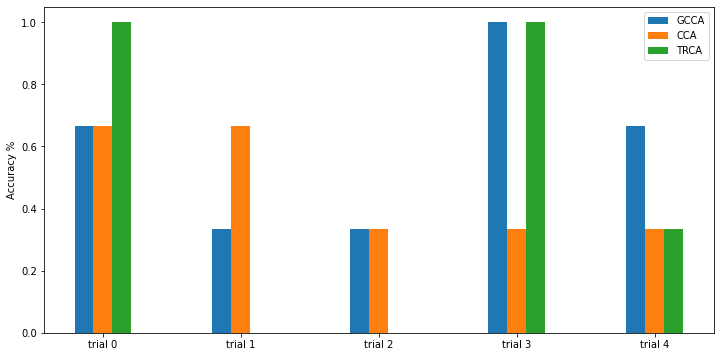

In [64]:
import matplotlib.pyplot as plt
import numpy as np

out = {p:[] for p in prefixes}

for trial in trials:
    for algo in prefixes:
        out[algo].append(len(cca_df[(cca_df['f_hat_'+algo] == cca_df.f_test) & (cca_df.trial == trial)])/len(stim_freqs))        

width = .275
Pos = np.array(range(Nt))*2
plt.figure(figsize=(12,6))
plt.bar(Pos - width, out['gcca'], width = width)
plt.bar(Pos, out['cca'], width = width)
plt.bar(Pos + width, out['trca'], width = width)
plt.xticks(Pos, [f'trial {i}' for i in trials])
plt.legend(['GCCA', 'CCA', 'TRCA'])
plt.ylabel('Accuracy %')
# plt.savefig('decode_acc.eps', format='eps')

In [98]:
from eeg_lib.trca import TRCA_SSVEP

f_idx = 0
trials = list(range(5))
trial = 1

train_indices = trials #list(set(trials)-{trial})
X_test = X[f_idx, :, -400:, trial]
X_train = X_ssvep[:, :, -400:, train_indices]

trca = TRCA_SSVEP(stim_freqs)
trca.fit(X_train)
trca.compute_corr(X_test)

{7: 0.7721717751785431, 10: -0.8027082067013425, 12: -0.7498955213598765}

In [99]:
from eeg_lib.trca import TRCA
from eeg_lib.synthetic import synth_data_tensor

np.random.seed(0)

noise_p = 0.1

X_trca =  synth_data_tensor(stim_freqs, 1000, 4, 5, noise_p, fs)
X_test = np.squeeze(synth_data_tensor(stim_freqs, 1000, 4, 1, noise_p, fs))

f_idx = 0
trca = TRCA()
trca.fit(X_trca[f_idx, :, :, :])
trca.compute_corr(X_test[f_idx, :, :])

0.5400562518554121

In [54]:
gcca.Chi_bar.shape

(3, 4, 1000)

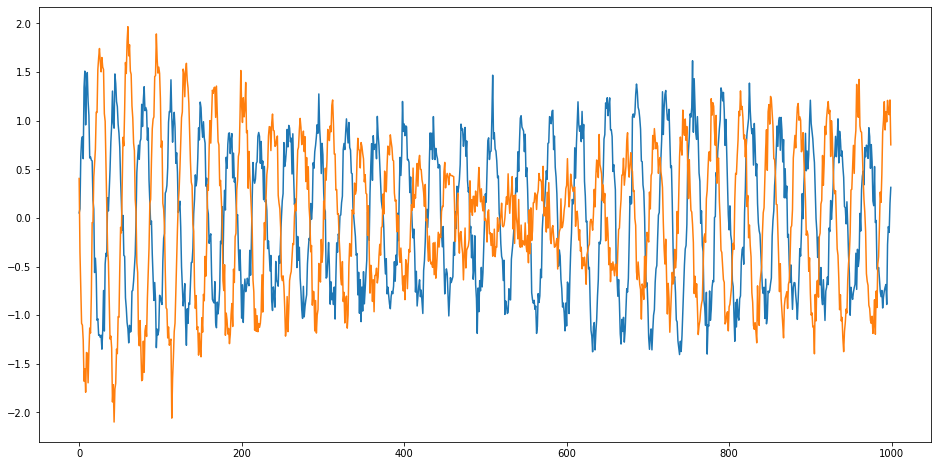

In [143]:
_, W = trca.get_eig()
w = W[:, 0]

plt.figure(figsize=(16,8))
plt.plot(X_trca[f_idx, 2, :, 2])
plt.plot(w.T.dot(X_trca[f_idx, :, :, 0]).T)

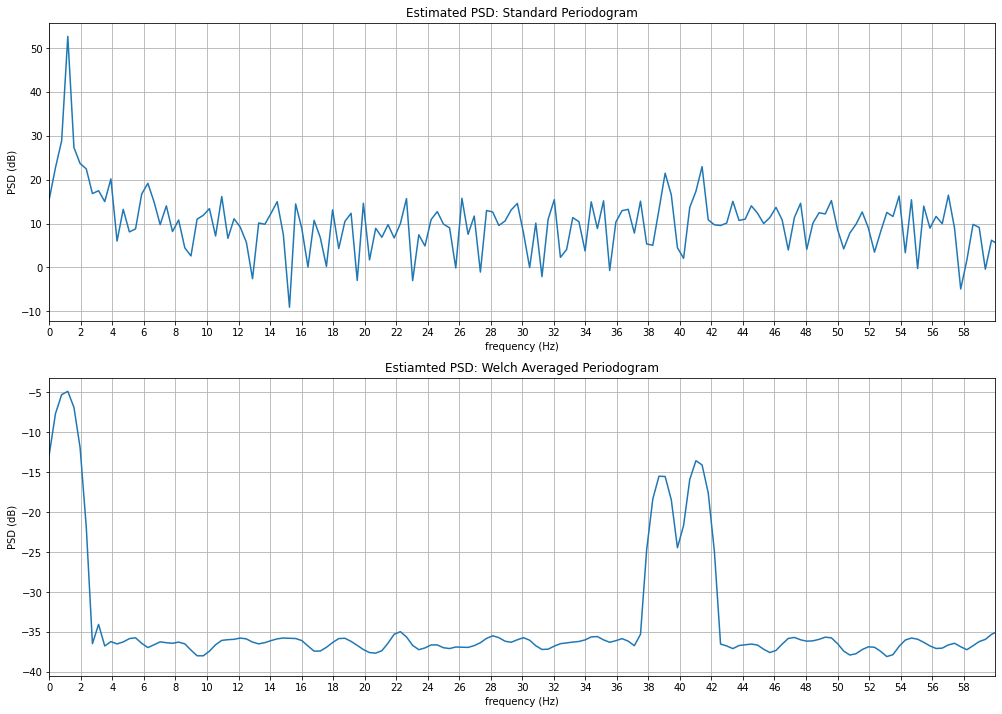

In [113]:
from eeg_lib.freq_analysis import plot_periodogram

Ndft = 512
plot_periodogram(trca.Y, 200, N=Ndft)

### GCCA: Synthetic data
Testing the generalised CCA decoding algorithm on synthetically generated SSVEP data

In [8]:
from eeg_lib.cca import GCCA

gcca = GCCA(7, 250)

gcca.fit(chi[0, :, :, :])


In [13]:
gcca.w_Chi_n.shape

(4,)

In [3]:
from eeg_lib.synthetic import synth_data_tensor, synth_X
from eeg_lib.cca import GCCA
from scipy.stats import pearsonr
import numpy as np

np.random.seed(0)

stim_freqs = [8, 10, 12]
Ns = 1000 # num samples (in time)
Nc = 4 # num channels
Nt = 5 # num trials
Nh = 5 # num harmonics in sinusoidal ref vector
noise_power = 0.1 # base noise power
fs = 200 # sampling freq


chi = synth_data_tensor(stim_freqs, Ns, Nc, Nt, noise_power, fs)
gcca = GCCA(stim_freqs, fs)

gcca.fit(chi)

# test GCCA
test_noise_power = noise_power+1

for f_test in stim_freqs:
    X_test = synth_X(f_test, Nc, Ns, noise_power=test_noise_power)
    result = {f: round(rho, 5) for f, rho in gcca.classify(X_test).items()}
    print(f"test_freq: {f_test}, result: {result}")

test_freq: 8, result: {8: 0.05804, 10: 0.00023, 12: 0.00636}
test_freq: 10, result: {8: 0.01615, 10: 0.09108, 12: 0.00032}
test_freq: 12, result: {8: 0.00086, 10: 0.00226, 12: 0.03103}


In [179]:
from scipy.linalg import block_diag
from eeg_lib.utils import solve_gen_eig_prob
import scipy

Nc = 3
Ns = 5
Nt = 2

chi = np.array([0.1*(i+1)*np.arange(Nc*Ns).reshape((Nc, Ns)) for i in range(Nt)]).transpose(1,2, 0)
X1, X2 = chi[:, :, 0], chi[:, :, 1] # for testing

# form inter-trial covariance matrix R
chi_c = np.vstack([chi[:, :, i] for i in range(Nt)])
R = chi_c.dot(chi_c.T)

# form inra-trial covariance matrix S
blocks = [chi[:, :, i].dot(chi[:, :, i].T) for i in range(Nt)]
S = block_diag(*blocks)


lam, V = scipy.linalg.eig((R-S), b=S) # solve generalise eig value problem
w = V[:, np.argmax(lam)].reshape((Nt, Nc)) # sort by largest eig vals in lam vector. TODO: check reshaping

Y = np.array([w[i, :].T.dot(chi[:, :, i]) for i in range(Nt)]) # form optimised reference matrix

In [249]:
from eeg_lib.cca import MsetCCA
from eeg_lib.cca import MsetCCA_SSVEP

np.random.seed(0)

mcca = MsetCCA_SSVEP(stim_freqs)
mcca.fit(chi)

Nc = 2
Ns = 1000
X_test = synth_X(12, Nc, Ns, noise_power=0.5)

mcca.classify(X_test)

{8: 0.18732606582441866, 10: 0.10094913011443264, 12: 0.5604858690416966}

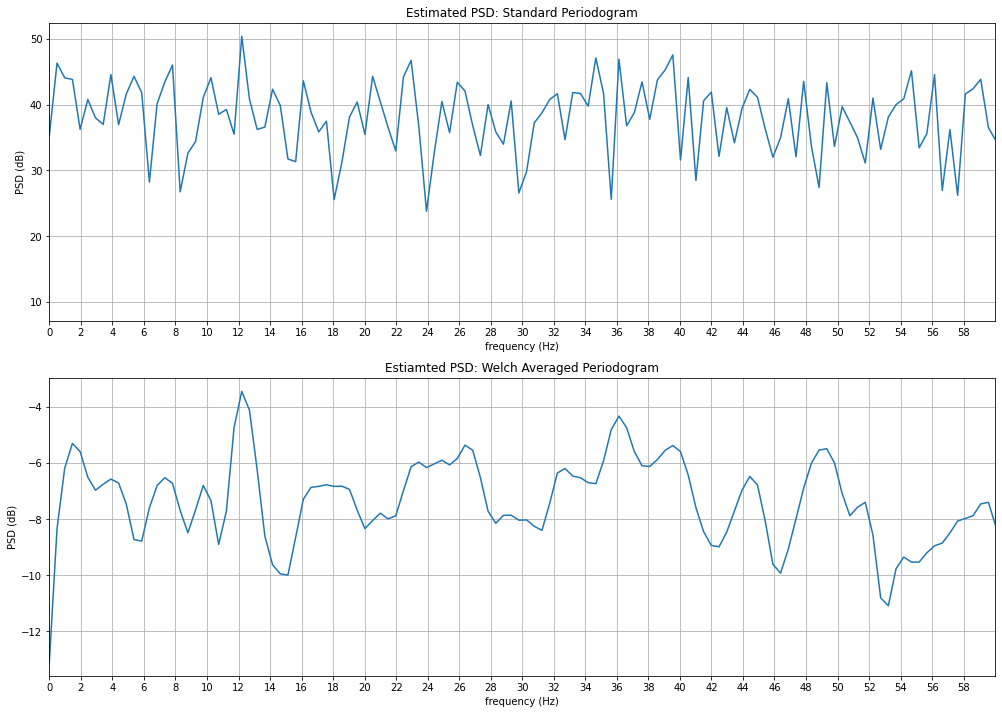

In [448]:
from eeg_lib.freq_analysis import plot_periodogram

Ndft = 512
plot_periodogram(X_test[1, :], 250, N=Ndft)

### Imperial Data: Adrien V1
#### Alpha band tests
First set of data recorded by Adrien using the "Frankenstein" headset. No SSVEP, only eyes closed vs eyes open. The section below explores whether the difference in energy in the alpha band (9-10Hz) can be distinguished between these two events

In [41]:
import glob

path = 'data/adrien/*' # use your path
all_files = glob.glob(path)

closed_lbls = ['1053', '1254', '1258', '1259', '1730']
open_lbls = ['1052', '1256', '1257', '1732', '1731']

closed_data = {k:[] for k in closed_lbls}
open_data = {k: [] for k in open_lbls}

for filename in all_files:
    print(f"Loading file {filename}")
    data = pd.read_csv(filename, delimiter = "\n").values
    lbl = filename.split('/')[-1][:4]
    if lbl in closed_lbls:
        closed_data[lbl] = data
    elif lbl in open_lbls:
        open_data[lbl] = data
    else:
        print("warning: unknown label encountered: ", lbl)
        
# create data matrices
start = 0
N = 8000
Xo = np.squeeze(np.array([d[start:N] for d in open_data.values()]))
Xc = np.squeeze(np.array([d[start:N] for d in closed_data.values()]))

Loading file data/adrien/1053 Recording.txt
Loading file data/adrien/1730 Recording.txt
Loading file data/adrien/1256 Recording.txt
Loading file data/adrien/1258 Recording.txt
Loading file data/adrien/1259 Recording.txt
Loading file data/adrien/1257 Recording.txt
Loading file data/adrien/1731 Recording.txt
Loading file data/adrien/1254 Recording.txt
Loading file data/adrien/1732 Recording.txt
Loading file data/adrien/1052 Recording.txt


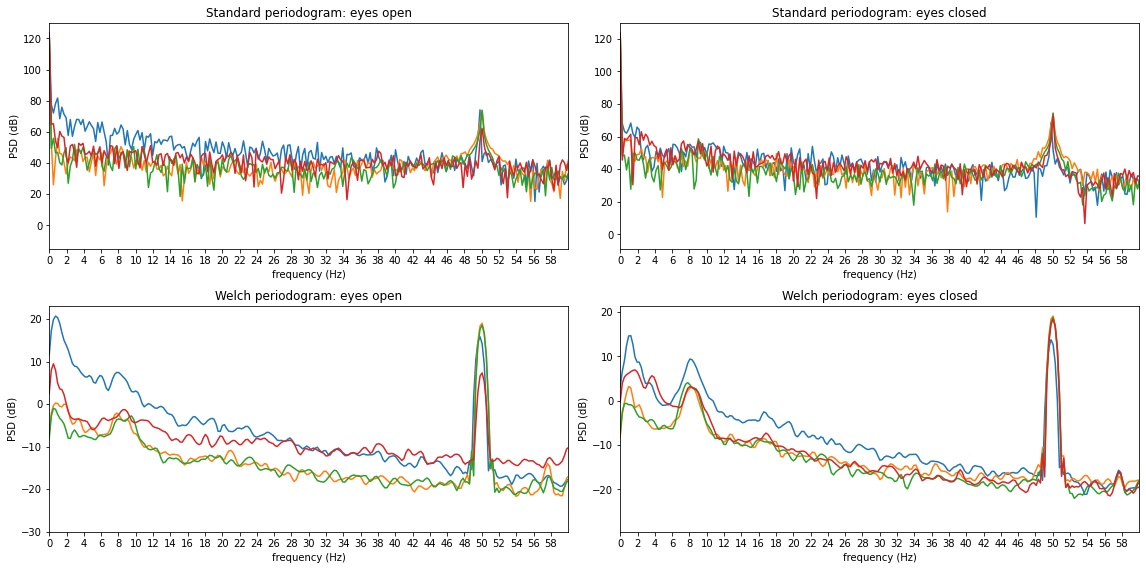

In [69]:
ssvep_f0 = 9
Ndft = 1024

fig, axes = plt.subplots(2,2, figsize=(16,8))
for i in range(min(Xo.shape[0], 4)):
    plot_periodogram(Xo[i, :], 250, N=Ndft, axes=axes[:, 0])

axes[0, 0].set_title('Standard periodogram: eyes open')
axes[1, 0].set_title('Welch periodogram: eyes open')

for i in range(min(Xc.shape[0], 4)):
    plot_periodogram(Xc[i, :], 250, N=Ndft, axes=axes[:, 1])
    
axes[0, 1].set_title('Standard periodogram: eyes closed')
axes[1, 1].set_title('Welch periodogram: eyes closed')

plt.savefig(f'plots/alpha_spectra_N{Ndft}.pdf', format='pdf')

### PSD Analysis: STFT
Extended PSD analysis using rolling short-term FFT 

In [ ]:
from eeg_lib.freq_analysis import plot_stft_spectra

fs = 200
win_len = 512 # window size in num samples

freq_map = {'F1': 10, 'F2':15}
f_ssvep = np.array(list(freq_map.values()))

ssvep_f0 = 10

target_df = df
x = target_df['chan4']

f, t, Sxx = signal.stft(x, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

f_ssvep = np.array(list(freq_map.values()))
n_plots = 6 # number of windows to consider. Takes first n windows from Sxx matrix
# plot
plot_stft_spectra(Sxx[:, :n_plots], f, ssvep_f0=ssvep_f0, f_ssvep=f_ssvep, figsize=(14,14))

print(f"Target SSVEP frequencies (Hz) at: {freq_map}. Running experiment with SSVEP_f0 = {ssvep_f0}Hz")
win_times = [(1/fs)*win_len*(1+i/2) for i in range(n_plots)]
print(F"Window start times in seconds: {win_times}")

## Adaptive Filtering

### Least Mean Squares (LMS)

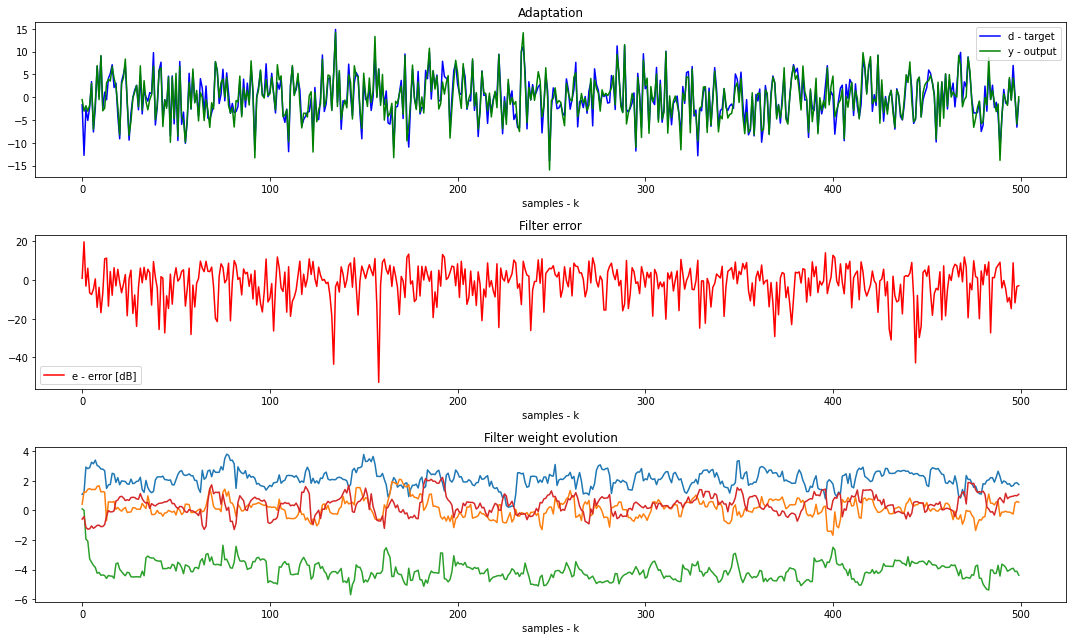

In [3]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 

# creation of data
N = 500
x = np.random.normal(0, 1, (N, 4)) # input matrix
v = np.random.normal(0, 1, N) # noise
d = 2*x[:,0] + 0.1*x[:,1] - 4*x[:,2] + 0.5*x[:,3] + v # target

# identification
f = pa.filters.FilterRLS(n=4, mu=0.1, w="random")
y, e, w = f.run(d, x)

# show results
plt.figure(figsize=(15,9))
plt.subplot(311);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output");plt.legend()
plt.subplot(312);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()

plt.subplot(313)
plt.plot(w)
plt.title("Filter weight evolution");plt.xlabel("samples - k")

plt.tight_layout()
plt.show()

In [380]:
def ref_sig_pair(f_ref, t):
    r_s = np.sin(2*np.pi*f_ref*t)#.reshape(-1, 1)
    r_c = np.cos(2*np.pi*f_ref*t)#.reshape(-1, 1)
    return r_s, r_c

def create_ref_signals(ref_freqs, t):
    if len(ref_freqs) == 0:
        raise ValueError("Need at least one reference frequency")
    R_s = np.zeros((len(t), len(ref_freqs)))
    R_c = np.zeros((len(t), len(ref_freqs)))
    for i, rf in enumerate(ref_freqs):
        R_s[:, i], R_c[:, i] = ref_sig_pair(rf, t)
    return R_s, R_c

def form_target(source, t, noise_power=1):
    w_d = np.random.normal(0, noise_power, (N, 1)) # ref noise
    #A = np.where(t > t[len(t)//2], 0.5, 1.5)
    target_sig = np.zeros((len(t)))
    for i in range(len(source['f'])):
        target_sig += source['A'][i]*np.sin(2*np.pi*source['f'][i]*t + source['phi'][i])
    target_sig = target_sig.reshape(-1,1) # clean target signal
    target = target_sig+w_d # noisy target signal
    return target_sig, target

def ma(x, win, min_periods=0):
    if len(x.shape) > 1:
        x = x.flatten()
    x = pd.Series(x)
    return x.rolling(win, min_periods=min_periods).mean()

In [391]:
eeg_target = Xraw[:, 0]
len(eeg_target)

1000

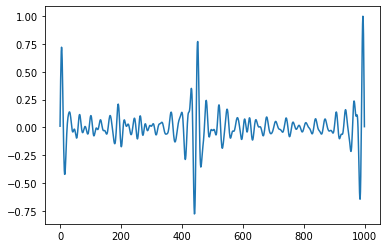

In [392]:
plt.plot(eeg_target/max(eeg_target))

In [385]:
eeg_target.shape

(200,)

In [395]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 
from scipy.ndimage.interpolation import shift

def measure_x(k):
    x = np.c_[r_s[k], r_c[k]].flatten()
    return x
#     return x_ale[k:k+M, :].T.flatten()
    
def measure_d(k):
    # meausure system output
    return target[k]

source = {
    'f': [7, 20], # sinusoidal components in source signal
    'A': [1.2, 0], # amplitudes of freq components
    'phi': [np.pi/8, 0] # phase of freq components
}

M = 2
# x_ale = shift(target.flatten(), M).reshape(-1, 1)

N = 500

fs = 200;
t = np.arange(N)/fs;

noise_power = 1
target_freqs = [10, 12]
R_s, R_c  = create_ref_signals(target_freqs, t)

# cleany signal, signal in WGN
# target_sig, target = form_target(source, t, noise_power=noise_power) 

target = (eeg_target/max(eeg_target))[:N]
target = target-np.mean(target)
    
Y = np.zeros((N, len(target_freqs)))
Y_pred = np.zeros((N, len(target_freqs)))
W = np.zeros((N, M, len(target_freqs)))

create_base_filt = lambda : pa.filters.FilterRLS(M, mu=0.99)
filts = [create_base_filt() for i in range(len(target_freqs))] # recursive least squares

#filt = pa.filters.FilterNSSLMS(n=2) # normalised sign sign lms
# filt = pa.filters.FilterGNGD(2, mu=0.01) # generalised normalised grad descent

for k in range(N): # iterate through time
    # measure input
    for i in range(len(target_freqs)):
        x = np.c_[R_s[k, i], R_c[k, i]].flatten() #measure_x(k)
        # predict new value
        y_pred = filts[i].predict(x)
        # do the important stuff with prediction output
        # measure output
        y = measure_d(k)
        # update filter
        filts[i].adapt(y, x)
        # log values
        Y[k, i] = y
        Y_pred[k, i] = y_pred
        W[k, :, i] = filts[i].w

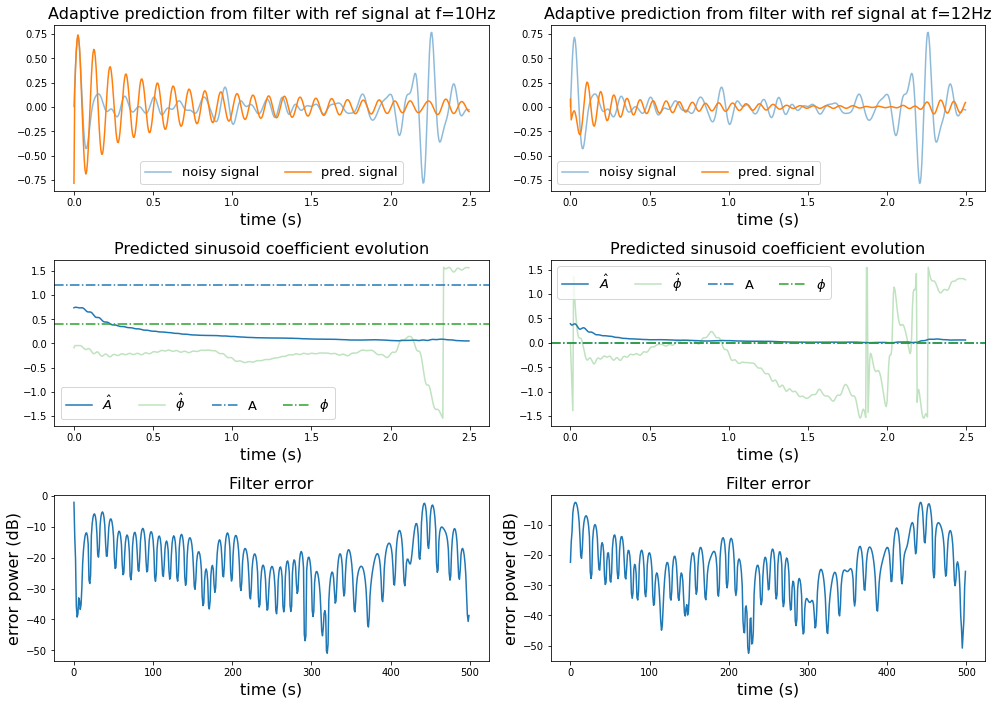

In [396]:
fig, axes = plt.subplots(3, len(target_freqs), figsize=(14,10))

t_ax = np.arange(Y.shape[0])/fs # time axis
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 13

for col in range(axes.shape[1]):
    ax0 = axes[0][col]
    ax0.set_title(f'Adaptive prediction from filter with ref signal at f={target_freqs[col]}Hz')
    ax0.plot(t, Y[:, col], alpha=0.5, label='noisy signal')
    ax0.plot(t, Y_pred[:, col], label='pred. signal')
#     ax0.plot(t, target_sig.flatten(), label='signal')
    ax0.legend(ncol=3)
    
    ax1 = axes[1][col]
    ax1.set_title('Predicted sinusoid coefficient evolution')
    ax1.plot(t, [np.linalg.norm(w) for w in W[:, :, col]], label='$\hat{A}$') # A_hat
    ax1.plot(t, [np.arctan(w[1]/w[0]) for w in W[:, :, col]], c='C2', label='$\hat{\phi}$', alpha=0.3) #phi_hat
    ax1.axhline(source['A'][col], c='C0', ls='-.', label='A')
    ax1.axhline(source['phi'][col], c='C2', ls='-.', label='$\phi$')
#     ax1.set_ylim([-0.5,2])
    ax1.legend(ncol=4)
    
    err_db = 10*np.log10((Y[:, col]-Y_pred[:, col])**2)
    ax2 = axes[2][col]
    ax2.set_title("Filter error");
    ax2.set_ylabel("error power (dB)")
    ax2.plot(ma(err_db, 3), label='')
#     ax2.set_ylim([-30, 15])
    
for ax in axes.flatten():
    ax.set_xlabel('time (s)')
    
fig.tight_layout(pad=1.5)

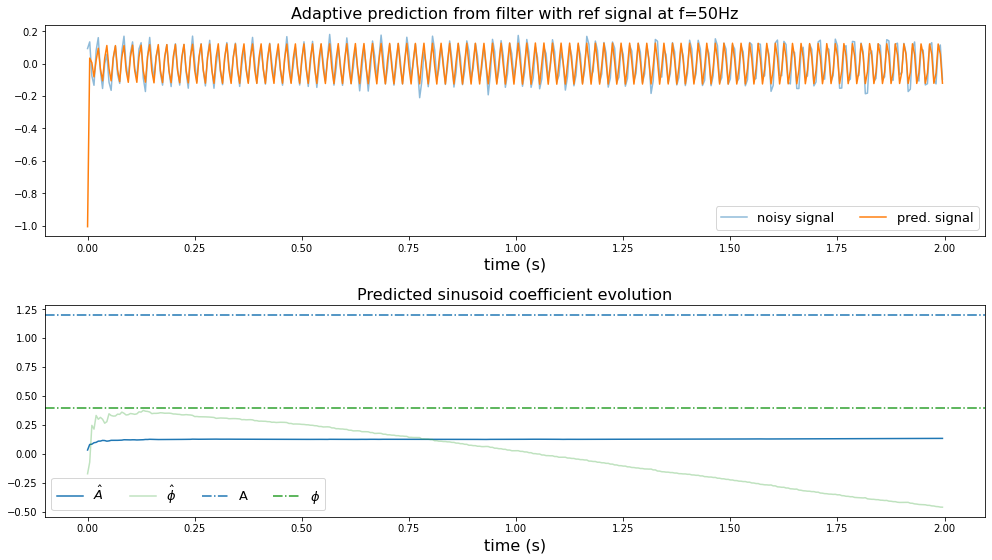

In [269]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 
from scipy.ndimage.interpolation import shift

def measure_x(k):
    x = np.c_[r_s[k], r_c[k]].flatten()
    return x
    
def measure_d(k):
    return target[k]

source = {
    'f': [7, 20], # sinusoidal components in source signal
    'A': [1.2, 0], # amplitudes of freq components
    'phi': [np.pi/8, 0] # phase of freq components
}

M = 2
N = 400

fs = 200;
t = np.arange(N)/fs;

noise_power = 1
target_freqs = [50]
R_s, R_c  = create_ref_signals(target_freqs, t)

# cleany signal, signal in WGN
target_sig, target = form_target(source, t, noise_power=noise_power) 

n = 700
target = (eeg_target/max(eeg_target))[n:N+n]
target = target-np.mean(target)
    
Y = np.zeros((N, len(target_freqs)))
Y_pred = np.zeros((N, len(target_freqs)))
W = np.zeros((N, M, len(target_freqs)))

create_base_filt = lambda : pa.filters.FilterRLS(M, mu=0.99)
filts = [create_base_filt() for i in range(len(target_freqs))] # recursive least squares

#filt = pa.filters.FilterNSSLMS(n=2) # normalised sign sign lms
# filt = pa.filters.FilterGNGD(2, mu=0.01) # generalised normalised grad descent


for k in range(N): # iterate through time
    for i in range(len(target_freqs)):
        # measure input
        x = np.c_[R_s[k, i], R_c[k, i]].flatten() #measure_x(k)
        # predict new value
        y = measure_d(k)
        y_pred = filts[i].predict(x) #- y
        # do the important stuff with prediction output
        # measure output
        # update filter
        filts[i].adapt(y, x)
        # log values
        Y[k, i] = y
        Y_pred[k, i] = y_pred
        W[k, :, i] = filts[i].w
        
fig, axes = plt.subplots(2, len(target_freqs), figsize=(14,8))
axes = axes.reshape(-1, 1)

t_ax = np.arange(Y.shape[0])/fs # time axis
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 13

for col in range(axes.shape[1]):
    ax0 = axes[0][col]
    ax0.set_title(f'Adaptive prediction from filter with ref signal at f={target_freqs[col]}Hz')
    ax0.plot(t, Y[:, col], alpha=0.5, label='noisy signal')
    ax0.plot(t, Y_pred[:, col], label='pred. signal')
    ax0.legend(ncol=3)
    
    ax1 = axes[1][col]
    ax1.set_title('Predicted sinusoid coefficient evolution')
    ax1.plot(t, [np.linalg.norm(w) for w in W[:, :, col]], label='$\hat{A}$') # A_hat
    ax1.plot(t, [np.arctan(w[1]/w[0]) for w in W[:, :, col]], c='C2', label='$\hat{\phi}$', alpha=0.3) #phi_hat
    ax1.axhline(source['A'][col], c='C0', ls='-.', label='A')
    ax1.axhline(source['phi'][col], c='C2', ls='-.', label='$\phi$')
    ax1.legend(ncol=4)
    
for ax in axes.flatten():
    ax.set_xlabel('time (s)')
    
fig.tight_layout(pad=1.5)

In [300]:
target_sig, target = form_target(source, t, noise_power=noise_power) 

target.shape

(400, 1)

In [301]:
from eeg_lib.fbcca import fbcca, fbcca_realtime

fbcca_realtime(target.reshape((1, -1)), [7], fs, num_harms=3, num_fbs=5)

[0.94458329]


999

In [302]:
from eeg_lib.trca import trca

# Task-related component analysis for functional neuroimaging and application to near-infrared spectroscopy data, Tanaka et al
data = np.random.randint(1,34,(10,600))
t = np.array([0,200,400])
Nb = 200
Y, V, D, S = trca(data, t, Nb)

In [270]:
y = Y[:, 0]
y50 = Y_pred[:, 0]
yfilt = y-y50

In [259]:
# y = np.sin(2*np.pi*t*50) + 0.2*np.sin(2*np.pi*t*7)
# y50 = 0.95*np.sin(2*np.pi*t*50)
# # yfilt = y-y50

# plt.plot(y)
# plt.plot(yfilt)

(-0.2, 0.2)

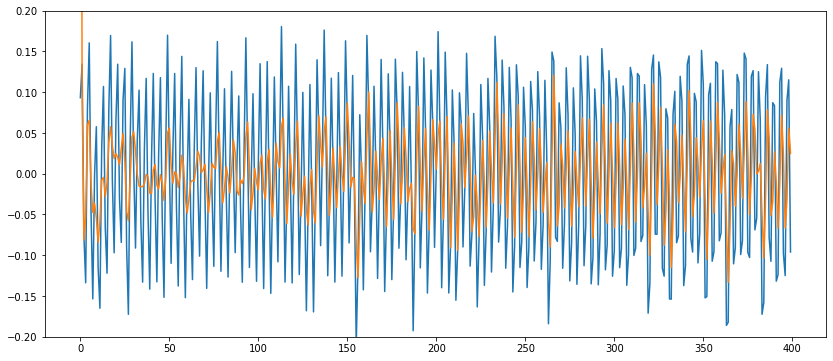

In [271]:
plt.figure(figsize=(14,6))
plt.plot(y)
# plt.plot(y50)
plt.plot(yfilt)
plt.ylim([-0.2, 0.2])

#### Experiments to try
- at the moment, I am considering independent filters for each ref. frequency. However, when the target signal is composed of multiple non-noise frequency components, the error signal will grow unavoidably as each independent filter only predicts the coefficients of its single reference sinusoid. I could try creating a **combined** filter that incorporates weights for all target frequencies (e.g. for 10 and 20Hz if those are our selected SSVEP frequencies). Then, the filter can predict the relative coefficient values of the target sinusoids to create a weighted ouput signal that will better match the target. 
- run experiments to determine expected amount of time to reach convergence under different noise conditions (convergence time seems to increase in noisier settings)
- try with non-stationary noise that evolves with time


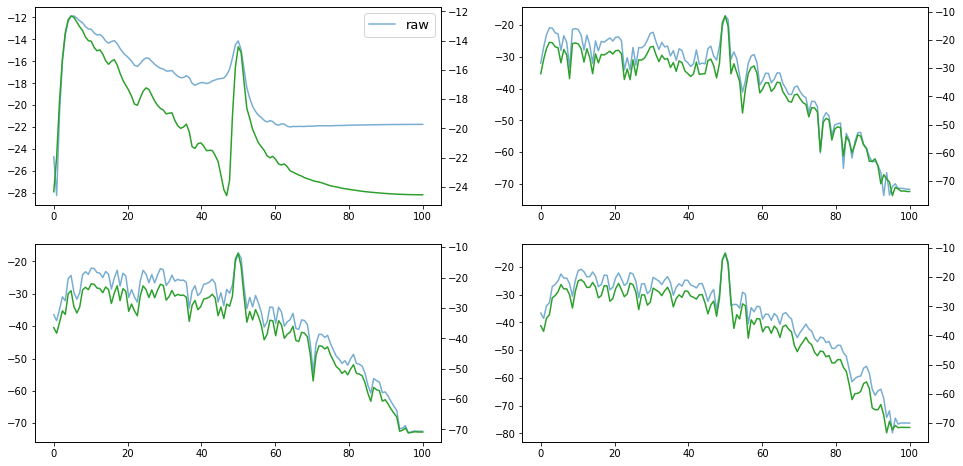

In [161]:
win_len = 256

f, t, Sxx_d = signal.stft(yfilt, fs, nperseg=win_len, noverlap=win_len//2, window='hann')
f, t, Sxx_y = signal.stft(y, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

fig, axes = plt.subplots(2,2, figsize=(16,8))
axes = axes.flatten()

for i in range(len(axes)):
    axes[i].plot(f, dB(np.abs(Sxx_d[:, i])), label='raw', alpha=0.6)
    ax2 = axes[i].twinx()
    ax2.plot(f, dB(np.abs(Sxx_y[:, i])), label='denoised', c='C2')

axes[0].legend()

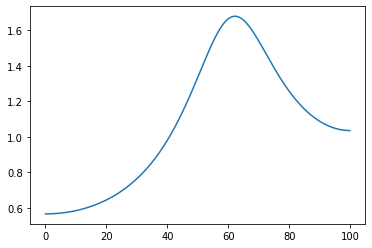

In [356]:
from scipy import signal

a = np.append([1], filt.w)
w,h = signal.freqz(b=[1], a=a)

plot_freq = lambda w,h: plt.plot(w, abs(h))
plot_freq(w/np.pi*100,h)

## EEG Steady-State Visual Evoked Potential Signals
> Database by Marco Aceves' PhD study

Each subject performed different tests which are provided in .csv format as follows: suppose you have a .csv which name is A001SB1_1 This means the data corresponds to group A (only Group A is provided at present), subject 001, Test SB1 (Five Box Visual Test), and first experiment (_1, there could be a repetition of the experiment which will be _2, _3, etc). The different tests are as follows: SB1 - Five Box Visual Test 1, SB2 - Five Box Visual Test 2, SB3 - Five Box Visual Test 3 (There are three different Five Box tests, these are not repetitions of the same test), SV1 - Visual Image Search, SM1 - Motor Images (Hand Shake Experiment). Since these experiments are visual tests, you may be interested in the electrodes O1 and O2. 

## SSVEP Study 2 (G. Acampora et al)

### Data acquisition
Data was acquired using a BCI headset built on top of the Olimex EEG-SMT, a two-channel differential input 10-bit analogue-digital converter (ADC) with a sampling frequency of 256 Hz. One channel out of two has been used for developing the proposed dataset.

### Experimental procedure
Subjects were seated on a chair, 70 cm away from a 15.6 inches monitor with a resolution of 1024×768 pixels, and a refresh rate of 60 Hz. The visual stimuli displayed on the monitor consisted of 4 alternating black-white squares with frequencies 8.57 Hz, 10 Hz, 12 Hz and 15 Hz respectively. The electrodes were positioned on the midline sagittal plane at the Frontal Parietal area (Fpz) and the Occipital area (Oz), according to the 10–20 system.

### Data collection
11 volunteers were equipped with the data acquisition headset and asked to focus on the visual stimuli, 16 s each one. Data is stored in eleven .csv files, one for each subject. Each file contains raw EEG data of the four stimuli frequencies.

In [2]:
path = 'data/SSVEP-Acampora/' # use your path
all_files = glob.glob(path + "/*.csv")

dfs = []

for filename in all_files:
    print(f"Loading file {filename}")
    df = pd.read_csv(filename, index_col=None, header=0, sep=';') # note: these files use ; sep
    dfs.append(df/1023)
    
dfs[0]

Loading file data/SSVEP-Acampora/subject2.csv
Loading file data/SSVEP-Acampora/subject3.csv
Loading file data/SSVEP-Acampora/subject1.csv
Loading file data/SSVEP-Acampora/subject4.csv
Loading file data/SSVEP-Acampora/subject5.csv
Loading file data/SSVEP-Acampora/subject7.csv
Loading file data/SSVEP-Acampora/subject6.csv
Loading file data/SSVEP-Acampora/subject11.csv
Loading file data/SSVEP-Acampora/subject10.csv
Loading file data/SSVEP-Acampora/subject8.csv
Loading file data/SSVEP-Acampora/subject9.csv


,F1,F2,F3,F4
0,0.400782,0.308895,0.732160,0.508309
1,0.501466,0.290323,0.722385,0.497556
2,0.499511,0.290323,0.721408,0.479961
3,0.480938,0.266862,0.716520,0.545455
4,0.461388,0.278592,0.694037,0.542522
...,...,...,...,...
4091,0.559140,0.506354,0.518084,0.601173
4092,0.547410,0.481916,0.473118,0.586510
4093,0.536657,0.523949,0.482893,0.644184
4094,0.520039,0.547410,0.527859,0.639296


In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [210]:
all_files[2]

'data/SSVEP-Acampora/subject1.csv'

Text(0.5, 1.0, 'Time domain signal')

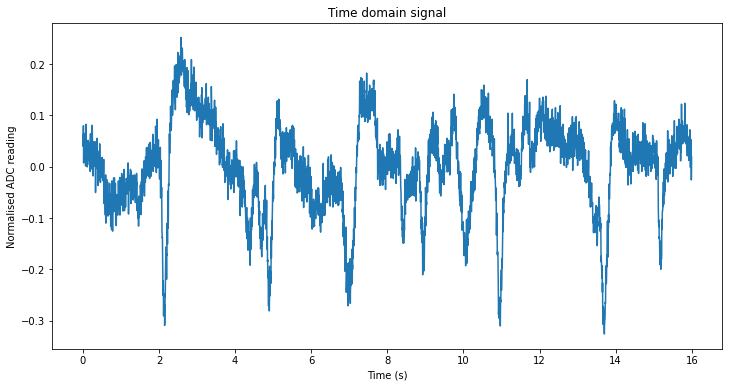

In [12]:
# set signal here
test_freq = 'F4' # which of the freq tests F1-F4
lp_filt = False

freq_map = {'F1': 8.75, 'F2': 10, 'F3': 12, 'F4':15}
x = dfs[2][test_freq].values
ssvep_f0 = freq_map[test_freq]

fs = 256 # sampling freq

x = x - np.mean(x) # mean center data - remove DC component

if lp_filt:
    print("Filtering with butterworth LP filter")
    x = butterworth_lowpass(x, 35, 256, 5)

fig, ax0 = plt.subplots(figsize=(12,6))
ax0.plot(np.arange(len(x))/fs, x)
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Normalised ADC reading')
ax0.set_title('Time domain signal')
# t = np.arange(len(x))/fs
# ax0.plot(t, np.sin(2*np.pi*ssvep_f0*t))
# ax0.set_xlim(0, 1)

In [13]:
win_len = 512 # window size in num samples
# f,t,Sxx = signal.spectrogram(x, fs=fs, nperseg=win_len, noverlap=win_len//2, mode='magnitude')
f, t, Sxx = signal.stft(x, fs, nperseg=win_len, noverlap=win_len//2, window='hann')

Sxx.shape # (nfft/2+1, n_windows) (real spectrum)
dB = lambda x: 10*np.log10(x)

Target SSVEP frequencies (Hz) at: {'F1': 8.75, 'F2': 10, 'F3': 12, 'F4': 15}. Running experiment with SSVEP_f0 = 15Hz
Window start times in seconds: [2.0, 3.0, 4.0]


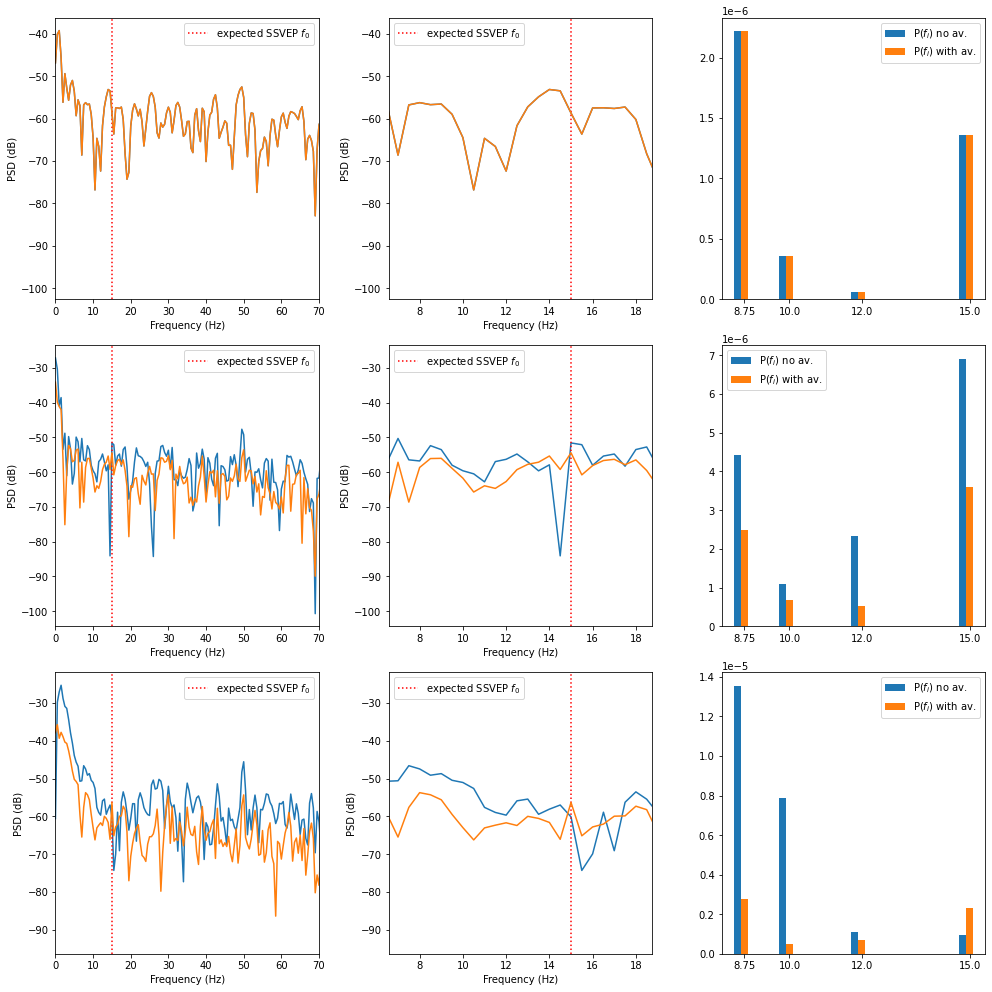

In [14]:
from eeg_lib.freq_analysis import plot_stft_spectra

f_ssvep = np.array(list(freq_map.values()))
n_plots = 3 # number of windows to consider. Takes first n windows from Sxx matrix
# plot
plot_stft_spectra(Sxx[:, :n_plots], f, ssvep_f0=ssvep_f0, f_ssvep=f_ssvep, recursive_av=True, figsize=(14,14))
print(f"Target SSVEP frequencies (Hz) at: {freq_map}. Running experiment with SSVEP_f0 = {ssvep_f0}Hz")
win_times = [(1/fs)*win_len*(1+i/2) for i in range(n_plots)]
print(F"Window start times in seconds: {win_times}")

Fundamental SSVEP frequency expected at 15Hz


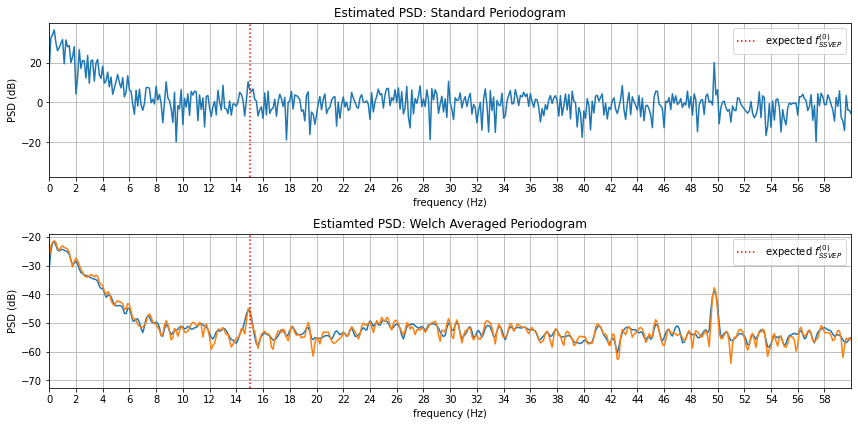

In [15]:
from eeg_lib.freq_analysis import plot_periodogram

plot_periodogram(x, ssvep_f0, fs, figsize=(12,6))
# plt.savefig('psd_plot.eps', format='eps')

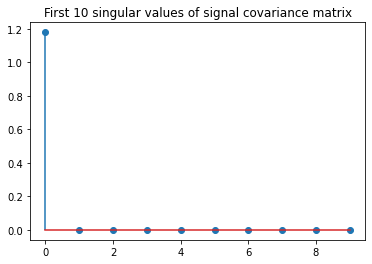

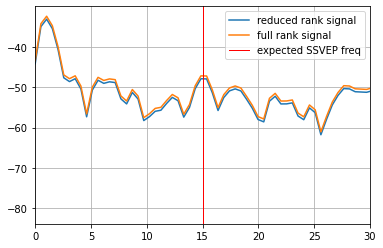

In [13]:
x_vec = x[:512].reshape(-1, 1) # only look at first 512 values = 512 * 1/256 = 2s
if np.mean(x) > 0.001:
    print("Warning: expected zero mean data for calculating covariance matrix")
x_vec.dot(x_vec.T)

U, S, Vh = np.linalg.svd(x_vec.dot(x_vec.T))
plt.stem(S[:10])
plt.title('First 10 singular values of signal covariance matrix')

x_lr = U[:,0].dot(S[0]).reshape(-1, 1).dot(Vh[0, :].reshape(1, -1)).flatten()

f_welch, Pxx_welch = signal.welch(U[:, 0], 256, nperseg=300, nfft=500) # rank-1 signal
f_welch_orig, Pxx_welch_orig = signal.welch(x_vec.flatten(), 256, nperseg=300, nfft=500) # full rank signal

plt.figure()
plt.plot(f_welch, dB(Pxx_welch), label='reduced rank signal')
plt.plot(f_welch_orig, dB(Pxx_welch_orig), label='full rank signal')
plt.xlim(0, 30)
# plt.axvline(8.75, lw='1.2', c='r')
plt.axvline(15, c='r', lw=1, label='expected SSVEP freq')
plt.grid()
plt.legend()

In [ ]:
from scipy.signal import butter,filtfilt
# Filter requirements.

def butterworth_lowpass(x, fc, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = fc / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, x)
    return y

In [ ]:
import numpy.fft as fft


def stft(x, Nwin, Nfft=None):
    """
    Short-time Fourier transform: convert a 1D vector to a 2D array
    The short-time Fourier transform (STFT) breaks a long vector into disjoint
    chunks (no overlap) and runs an FFT (Fast Fourier Transform) on each chunk.
    The resulting 2D array can 
    Parameters
    ----------
    x : array_like
        Input signal (expected to be real)
    Nwin : int
        Length of each window (chunk of the signal). Should be ≪ `len(x)`.
    Nfft : int, optional
        Zero-pad each chunk to this length before FFT. Should be ≥ `Nwin`,
        (usually with small prime factors, for fastest FFT). Default: `Nwin`.
    Returns
    -------
    out : complex ndarray
        `len(x) // Nwin` by `Nfft` complex array representing the STFT of `x`.
    
    See also
    --------
    istft : inverse function (convert a STFT array back to a data vector)
    stftbins : time and frequency bins corresponding to `out`
    """
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    # reshape into array `Nwin` wide, and as tall as possible. This is
    # optimized for C-order (row-major) layouts.
    arr = np.reshape(x[:Nwindows * Nwin], (-1, Nwin))
    stft = fft.rfft(arr, Nfft)
    return stft


def stftbins(x, Nwin, Nfft=None, d=1.0):
    """
    Time and frequency bins corresponding to short-time Fourier transform.
    Call this with the same arguments as `stft`, plus one extra argument: `d`
    sample spacing, to get the time and frequency axes that the output of
    `stft` correspond to.
    Parameters
    ----------
    x : array_like
        same as `stft`
    Nwin : int
        same as `stft`
    Nfft : int, optional
        same as `stft`
    d : float, optional
        Sample spacing of `x` (or 1 / sample frequency), units of seconds.
        Default: 1.0.
    Returns
    -------
    t : ndarray
        Array of length `len(x) // Nwin`, in units of seconds, corresponding to
        the first dimension (height) of the output of `stft`.
    f : ndarray
        Array of length `Nfft`, in units of Hertz, corresponding to the second
        dimension (width) of the output of `stft`.
    """
    Nfft = Nfft or Nwin
    Nwindows = x.size // Nwin
    t = np.arange(Nwindows) * (Nwin * d)
    f = fft.rfftfreq(Nfft, d)
    return t, f